# LMIS Emitter Classification
---
---

### Imports and Globals

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import mygraphs as mg
import numpy as np
import os
import shutil
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# from keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc
import pickle
from tensorflow.keras.optimizers import Adam



# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# style seaborn darkgrid
plt.style.use('seaborn-darkgrid')


In [3]:
# Create a dataframe to store model results
model_results_df = pd.DataFrame(columns=['Model', 'Scale Factor', 'Train Accuracy', 'Val Accuracy', 'Test Accuracy'])

In [4]:
# check the image counts and set the splits directories
train_dir = 'data/raw/images_sorted_binary/split/Train'
print('====Train Directory====')
# get_folder_counts(train_dir)
val_dir = 'data/raw/images_sorted_binary/split/Validation'
print('====Validation Directory====')
# get_folder_counts(val_dir)
test_dir = 'data/raw/images_sorted_binary/split/Test'
print('====Test Directory====')
# get_folder_counts(test_dir)

====Train Directory====
====Validation Directory====
====Test Directory====


In [5]:
# create a function to make the train, validation, and test directories
def make_train_val_test_split_folders(data_dir, val_size=0.2, test_size=0.2):
    # initialize the random seed
    np.random.seed(42)

    # create the source and destination directories
    source_dir = os.path.join(data_dir, 'Unsplit')
    dest_dir = os.path.join(data_dir, 'Sets')
    train_dir = os.path.join(dest_dir, 'Train')
    val_dir = os.path.join(dest_dir, 'Validation')
    test_dir = os.path.join(dest_dir, 'Test')
    
    # create the destination directories if they don't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    # create a list of unique classes
    classes = os.listdir(source_dir)

    # create a directory for each class in the destination directories
    dest_dirs = [train_dir, val_dir, test_dir]
    for dest_dir in dest_dirs:
        for class_name in classes:
            class_dir = os.path.join(dest_dir, class_name)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)

    
    # create an array of lists to store the file names for each class
    class_dir_dict = {}
    for class_name in classes:
        class_dir = os.path.join(source_dir, class_name)
        file_list = os.listdir(class_dir)
        class_dir_dict[class_name] = file_list

    # get the sample sizes
    val_contamination_size = int(len(class_dir_dict['Contamination']) * val_size)
    test_contamination_size = int(len(class_dir_dict['Contamination']) * test_size)
    val_pass_size = int(len(class_dir_dict['PASS']) * val_size)
    test_pass_size = int(len(class_dir_dict['PASS']) * test_size)
    val_split_size = int(len(class_dir_dict['Split']) * val_size)
    test_split_size = int(len(class_dir_dict['Split']) * test_size)
    val_dmg_size = int(len(class_dir_dict['Damage']) * val_size)
    test_dmg_size = int(len(class_dir_dict['Damage']) * test_size)
    val_etch_size = int(len(class_dir_dict['Etch']) * val_size)
    test_etch_size = int(len(class_dir_dict['Etch']) * test_size)
    # print the sample sizes
    print(f'         Validation Set - Pass: {val_pass_size}')
    print(f'Validation Set - Contamination: {val_contamination_size}')
    print(f'        Validation Set - Split: {val_split_size}')
    print(f'       Validation Set - Damage: {val_dmg_size}')
    print(f'       Validation Set - Etch: {val_etch_size}')
    print('='*50)
    print(f'               Test Set - Pass: {test_pass_size}')
    print(f'      Test Set - Contamination: {test_contamination_size}')
    print(f'              Test Set - Split: {test_split_size}')
    print(f'             Test Set - Damage: {test_dmg_size}')
    print(f'             Test Set - Etch: {test_etch_size}')
    print('='*50)

    # First copy over the test files
    for class_name in classes:
        class_src_dir = os.path.join(source_dir, class_name)
        class_dest_dir = os.path.join(test_dir, class_name)
        file_list = class_dir_dict[class_name]
        if class_name == 'Contamination':
            sample_size = test_contamination_size
        elif class_name == 'PASS':
            sample_size = test_pass_size
        elif class_name == 'Split':
            sample_size = test_split_size
        elif class_name == 'Damage':
            sample_size = test_dmg_size
        elif class_name == 'Etch':
            sample_size = test_etch_size
        print(f'Copying {sample_size} of files from {class_src_dir} to {class_dest_dir}')
        test_files = np.random.choice(file_list, sample_size, replace=False)
        print(f'Files left in {class_name}: {len(class_dir_dict[class_name])}')
        for file in test_files:
            class_dir_dict[class_name].remove(file)
            print(f'Copying {file} from {class_src_dir} to {class_dest_dir}')
            shutil.copyfile(os.path.join(class_src_dir, file), os.path.join(class_dest_dir, file))
        print(f'Files left in {class_name}: {len(class_dir_dict[class_name])}')


    # Next copy over the val files
    for class_name in classes:
        class_src_dir = os.path.join(source_dir, class_name)
        class_dest_dir = os.path.join(val_dir, class_name)
        file_list = class_dir_dict[class_name]
        if class_name == 'Contamination':
            sample_size = val_contamination_size
        elif class_name == 'PASS':
            sample_size = val_pass_size
        elif class_name == 'Split':
            sample_size = val_split_size
        elif class_name == 'Damage':
            sample_size = val_dmg_size
        elif class_name == 'Etch':
            sample_size = val_etch_size
        print(f'Copying {sample_size} of files from {class_src_dir} to {class_dest_dir}')
        val_files = np.random.choice(file_list, sample_size, replace=False)
        print(f'Files left in {class_name}: {len(class_dir_dict[class_name])}')
        for file in val_files:
            class_dir_dict[class_name].remove(file)
            print(f'Copying {file} from {class_src_dir} to {class_dest_dir}')
            shutil.copyfile(os.path.join(class_src_dir, file), os.path.join(class_dest_dir, file))
        print(f'Files left in {class_name}: {len(class_dir_dict[class_name])}')

    # Copy the rest of the files to the train directory
    for class_name in classes:
        class_src_dir = os.path.join(source_dir, class_name)
        class_dest_dir = os.path.join(train_dir, class_name)
        file_list = class_dir_dict[class_name]
        print(f'Copying the rest of the files from {class_src_dir} to {class_dest_dir}')
        for file in file_list:
            src_file = os.path.join(class_src_dir, file)
            dest_file = os.path.join(class_dest_dir, file)
            print(f'Copying {src_file} to {dest_file}')
            shutil.copyfile(src_file, dest_file)


data_dir = 'Data\Raw\images_sorted_multiclass'
make_train_val_test_split_folders(data_dir, val_size=0.15, test_size=0.15)

         Validation Set - Pass: 376
Validation Set - Contamination: 249
        Validation Set - Split: 178
       Validation Set - Damage: 92
       Validation Set - Etch: 155
               Test Set - Pass: 376
      Test Set - Contamination: 249
              Test Set - Split: 178
             Test Set - Damage: 92
             Test Set - Etch: 155
Copying 249 of files from Data\Raw\images_sorted_multiclass\Unsplit\Contamination to Data\Raw\images_sorted_multiclass\Sets\Test\Contamination
Files left in Contamination: 1666
Copying 45616.tif from Data\Raw\images_sorted_multiclass\Unsplit\Contamination to Data\Raw\images_sorted_multiclass\Sets\Test\Contamination
Copying 45939.tif from Data\Raw\images_sorted_multiclass\Unsplit\Contamination to Data\Raw\images_sorted_multiclass\Sets\Test\Contamination
Copying 183272.tif from Data\Raw\images_sorted_multiclass\Unsplit\Contamination to Data\Raw\images_sorted_multiclass\Sets\Test\Contamination
Copying 44062.tif from Data\Raw\images_sorted_mu

In [21]:
def report_multi_results(model_name, 
                         scale_factor, 
                         model, 
                         test_generator, 
                         history=None, 
                         pass_adjustment=0.0, 
                         metric='categorical_accuracy',
                         val_metric='val_categorical_accuracy'):
    plt.style.use('seaborn-darkgrid')
    plt.style.context('seaborn-darkgrid')



    # Predict the classes of the test images
    y_test_prob = model.predict(test_generator)

    # Adjust the pass class of the probability array by the pass_adjustment
    y_test_prob[:, 2] = y_test_prob[:, 2] + pass_adjustment
  
    # Get the predicted classes
    test_pred_classes = np.argmax(y_test_prob, axis=1)

    if history is not None:
        # find the index of the best val_accuracy in the history
        best_val_accuracy = max(history.history[val_metric])
        best_val_accuracy_index = history.history[val_metric].index(best_val_accuracy)
        # get the training accuracy at the best val_accuracy
        best_train_accuracy = history.history[metric][best_val_accuracy_index]
        # print the training accuracy
        print('='*50)
        print(f'  Training Accuracy: {best_train_accuracy:.3f}')
        # print the validation accuracy
        print(f'Validation Accuracy: {best_val_accuracy:.3f}')
        # print the test accuracy
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    print(f'      Test Accuracy: {test_accuracy:.3f}')
    print('='*50)


    # Get the true test classes
    y_test_true = test_generator.classes
    # Generate a classification report
    report = classification_report(y_test_true, test_pred_classes)
    print(report)
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_true, test_pred_classes)

    # Display the confusion matrix
    class_labels = list(test_generator.class_indices.keys())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    # dark background
    #plt.style.use('dark_background')
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()




    # Create the ROC curve plot for each class in the test data
    lb = LabelBinarizer()
    true_classes_binarized = lb.fit_transform(y_test_true)
    # get the fpr, tpr and roc_auc for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], y_test_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Plot the ROC curve
    plt.figure(figsize=(6, 5.5))
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label=f'(area={roc_auc[i]:.2f}) {class_labels[i]}')
    plt.plot([0, 1], [0, 1], 'k--', color='red')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(False)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    if history is not None:
        # Display a graph of accuracy for the training and validation sets by epoch
        plt.plot(history.history[metric], label='accuracy')
        plt.plot(history.history[val_metric], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        # add title and labels
        plt.title(f'{model_name} Accuracy')
        plt.gca().get_lines()[0].set_color('red')
        plt.gca().get_lines()[1].set_color('blue')
        plt.legend(loc='lower right')
        plt.show()

        # Save the results to the dataframe
        if model_name not in model_results_df['Model'].values:
            model_results_df.loc[len(model_results_df)] = [model_name, scale_factor, best_train_accuracy, best_val_accuracy, test_accuracy]
        else:
            model_results_df.loc[model_results_df['Model'] == model_name, 'Scale Factor'] = scale_factor
            model_results_df.loc[model_results_df['Model'] == model_name, 'Train Accuracy'] = best_train_accuracy
            model_results_df.loc[model_results_df['Model'] == model_name, 'Val Accuracy'] = best_val_accuracy
            model_results_df.loc[model_results_df['Model'] == model_name, 'Test Accuracy'] = test_accuracy
    

---
### EDA with CSVs

In [6]:
df = pd.read_csv("Data\\LMIS Failures.csv")
df.head()

,DateTime,Coil_SN,Cone_Ht,Tip_Radius,Cone_Offset,Comments,PassFail,Class
0,3/1/2024 7:24,40801,111.9,8.76,2.9,NaN,PASS,PASS
1,3/1/2024 7:26,40802,116,7.51,5.5,NaN,PASS,PASS
2,3/1/2024 7:27,40803,121.3,9.55,5.8,NaN,PASS,PASS
3,3/1/2024 7:29,40804,118.9,10.19,1.8,NaN,PASS,PASS
4,3/1/2024 7:30,40805,119.9,10.14,3.7,NaN,PASS,PASS


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24770 entries, 0 to 24769
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DateTime     24770 non-null  object 
 1   Coil_SN      24770 non-null  int64  
 2   Cone_Ht      24770 non-null  object 
 3   Tip_Radius   24770 non-null  float64
 4   Cone_Offset  24770 non-null  float64
 5   Comments     12393 non-null  object 
 6   PassFail     24770 non-null  object 
 7   Class        24770 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.5+ MB


In [8]:
df = df[df['Class'] != 'NO IMAGE']

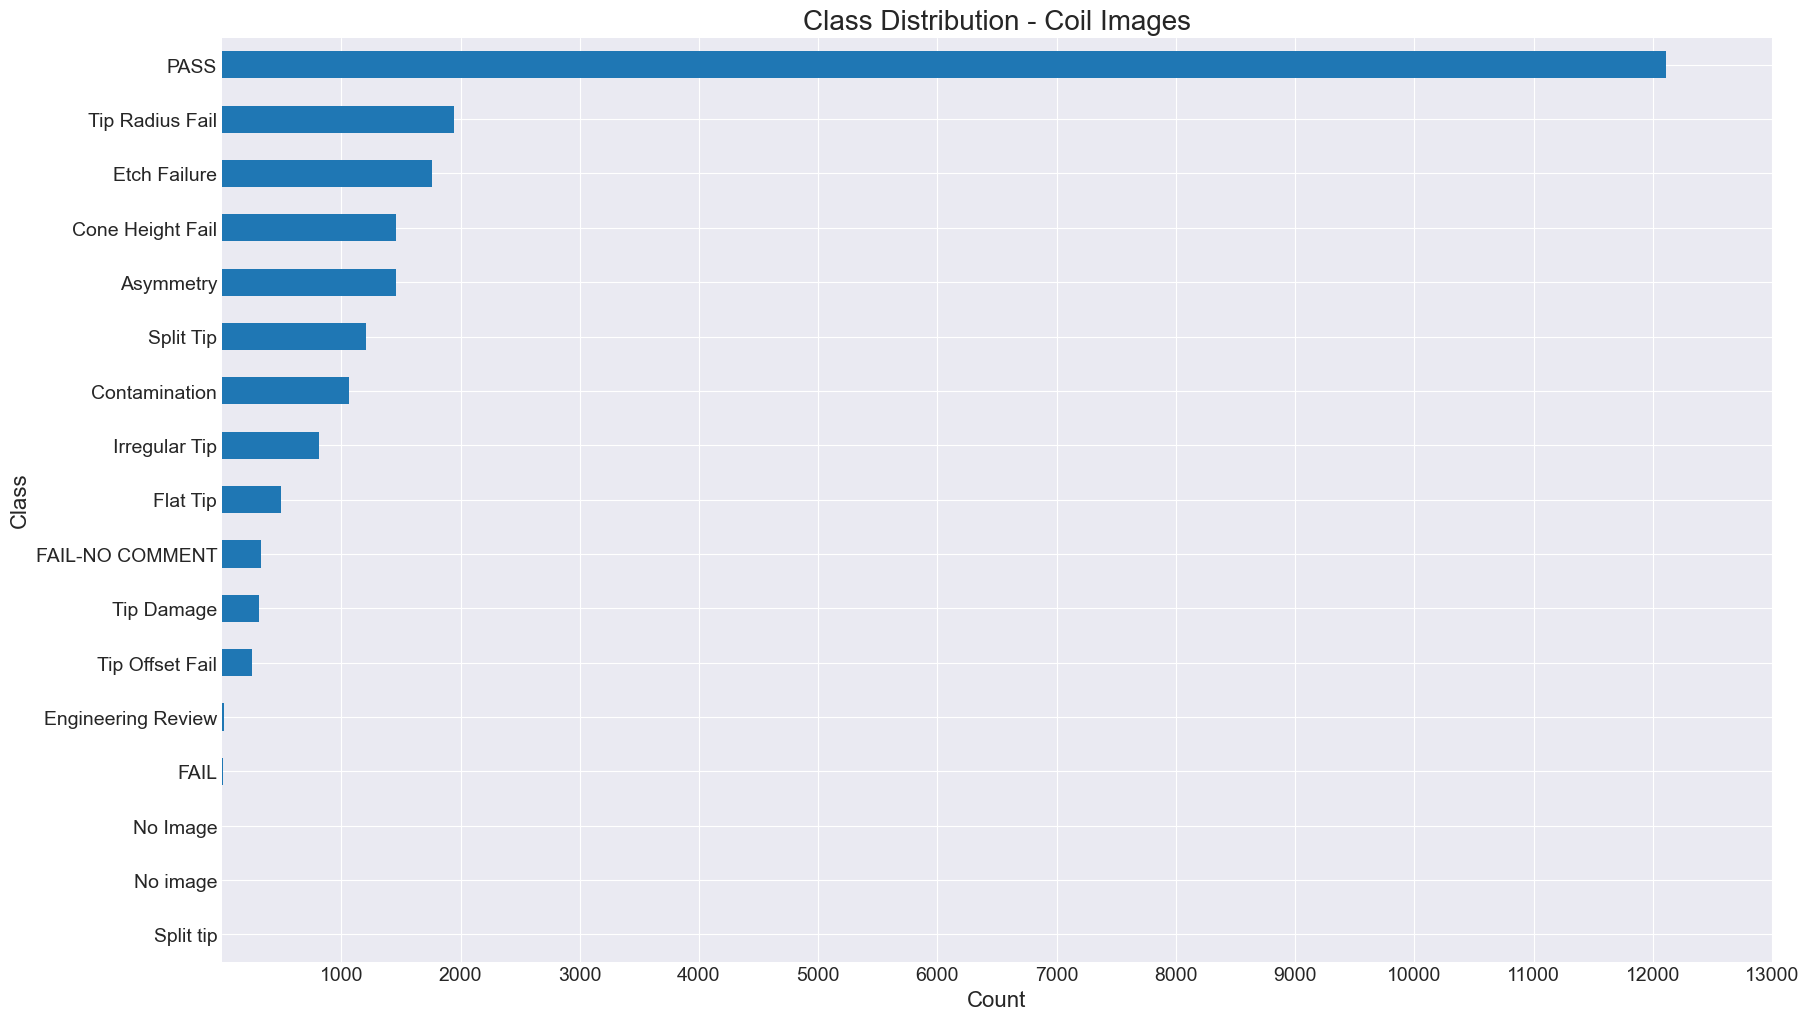

In [9]:

def display_class_distribution(df, class_column='Class', set_name='Coil Images'):
    # seaborn darkgrid style
    plt.style.use('seaborn-darkgrid')

    # Create a bar graph of class distribution
    df[class_column].value_counts().plot(kind='barh')  # Changed to 'barh' for horizontal bars

    plt.xlabel('Count')  # Corrected to use plt.xlabel for setting the x-axis label
    plt.ylabel('Class')  # Corrected to use plt.ylabel for setting the y-axis label
    plt.title('Class Distribution - Coil Images')  # Set the title

    plt.gcf().set_size_inches(20, 12)  # Corrected method to resize the figure

    # order the bars with the most frequent class on top
    plt.gca().invert_yaxis()

    max_count = df[class_column].value_counts().max()

    # x-ticks at 1000
    plt.xticks(range(1000, max_count+1000, 1000))

    # increase the font size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Count', fontsize=16)
    plt.ylabel('Class', fontsize=16)
    plt.title(f'Class Distribution - {set_name}', fontsize=20)

    plt.show()  # Display the plot

display_class_distribution(df)



In [ ]:
# This function takes moves images in the source directory to class directories
def move_images_to_class_dirs(df, src_dir, dest_dir, class_col='Class', img_col='SN'):


    # create the destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # create a list of unique classes
    classes = df[class_col].unique()

    # create a directory for each class
    for class_name in classes:
        class_dir = os.path.join(dest_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

    counter = 0
    # search the source directory for an image that contains the SN
    for index, row in df.iterrows():
        sn = str(row[img_col])
        class_name = row[class_col]

        # find the image file
        for root, dirs, files in os.walk(src_dir):
            for file in files:
                if sn in file:
                    try:
                        src_file = os.path.join(root, file)
                    except:
                        print(f"Read Error: {file}")
                    try:
                        dest_file = os.path.join(dest_dir, class_name, file)
                        shutil.copyfile(src_file, dest_file)
                        counter += 1
                        print(f"{counter} - Copying {src_file} to {dest_file}")
                    except:
                        print(f"Copy Error: {file}")




# move_images_to_class_dirs(df, 'Data\\Raw\\Coil_Images', 'Data\\Raw\\images_sorted')
# move_images_to_class_dirs(df, 'Data\\Raw\\Welded_Images', 'Data\\Raw\\images_sorted')

In [44]:
df_weld = pd.read_csv("Data\\LMIS Failures_weld.csv")

In [ ]:
display_class_distribution(df_weld, 'Failure Description', 'Weld Images')

In [46]:
# get rid of all df_weld rows that are not Failure Description = 'SEM:...' or 'Pass'
df_weld = df_weld[(df_weld['Failure Description'].str.contains('SEM:')) | (df_weld['Failure Description'] == 'Pass')]

# remove the 'SEM:' prefix from the Failure Description
df_weld['Failure Description'] = df_weld['Failure Description'].str.replace('SEM:', '')
df_weld['Failure Description'] = df_weld['Failure Description'].str.replace('Pass', 'PASS')

# rename the 'Failure Description' column to 'Class'
df_weld.rename(columns={'Failure Description': 'Class'}, inplace=True)

In [ ]:
display_class_distribution(df_weld, 'Class', 'Weld Images')

In [ ]:
df = df.drop(columns=['DateTime', 'Cone_Ht', 'Tip_Radius', 'Cone_Offset', 'Comments', 'PassFail'], axis=1)
df.rename(columns={'Coil_SN': 'SN'}, inplace=True)
df.head()

In [ ]:
df_weld = df_weld.drop(columns=['SEM_Date', 'Cone_SN'], axis=1)
df_weld.rename(columns={'LMISN': 'SN'}, inplace=True)
df_weld.head()

In [ ]:
# merge the two dataframes
df = pd.concat([df, df_weld], ignore_index=True)
df.info()

In [ ]:
# strip leading and trailing whitespace from the 'Class' column
df['Class'] = df['Class'].map(str.strip)
df.head()

In [ ]:
display_class_distribution(df, 'Class', 'All Images')

In [53]:
# # remove rows with classifications that have less than 1000 occurrences
# df = df[df['Class'].map(df['Class'].value_counts()) > 1000]

In [54]:
# display_class_distribution(df, 'Class', 'All Images')

In [55]:
class_nda_name_dict = {
    'Tip Radius Fail': 'Fail_A',
    'Etch Failure': 'Fail_B',
    'Contamination': 'Fail_C',
    'Split Tip': 'Fail_D',
    'Cone Height Fail': 'Fail_E',
    'Asymmetry': 'Fail_F',
    'Tip Damage': 'Fail_G'
}

#df.loc[:, 'Class'] = df['Class'].replace(class_name_dict)


In [ ]:
display_class_distribution(df, 'Class', 'All Images')

In [ ]:
df['Class'].value_counts()

In [ ]:
df.head()

---
### Images from Folders

In [17]:
# loop through each folder in the 'images_sorted' directory and print the number of files in each folder
def get_folder_counts(data_dir='Data\\Raw\\images_sorted_multiclass'):
    classes = os.listdir(data_dir)
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        file_list = os.listdir(class_dir)
        print(f'Class: {class_name} - {len(file_list)} files')

get_folder_counts()


Class: Contamination - 1215 files
Class: Etch Failure - 1713 files
Class: PASS - 1499 files
Class: Split Tip - 1333 files
Class: Tip Damage - 931 files


---
### Have a look at some images

Create a Crop and Resize function for preprocessing the images in the pipeline

In [2]:
# create a function to change the pixel value of the bottom 60 rows of an image to 0
from tensorflow.image import resize

def crop_and_resize(image, 
                    original_height=943, 
                    original_width=1024,
                    percent_header_crop = 10,        # in % of height
                    percent_footer_crop = 6.3,       # in % of height
                    percent_left_crop = 10,         # in % of width
                    percent_right_crop = 10,        # in % of width
                    scale_factor=1.0):
    
    # calculate the new height and width and resize the image
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)
    resized_image = resize(image, [new_height, new_width])

    # calculate the number of pixels to crop from each side
    header_crop_px = int(new_height * percent_header_crop / 100)
    footer_crop_px = -int(new_height * percent_footer_crop / 100)
    left_crop_px = int(new_width * percent_left_crop / 100)
    right_crop_px = -int(new_width * percent_right_crop / 100)

    # crop the image, deal with the special cases where the crop is 0
    if footer_crop_px == 0 and right_crop_px == 0:
        cropped_image = resized_image[header_crop_px:, left_crop_px:, :]   
    elif footer_crop_px == 0:
        cropped_image = resized_image[header_crop_px:, left_crop_px:right_crop_px, :]
    elif right_crop_px == 0:
        cropped_image = resized_image[header_crop_px:footer_crop_px, left_crop_px:, :]
    else:
        cropped_image = resized_image[header_crop_px:footer_crop_px, left_crop_px:right_crop_px, :]

    # resize the cropped image
    cropped_resized_image = resize(cropped_image, [new_height, new_width])
    resized_image = cropped_resized_image.numpy().reshape(new_height, new_width)
    return np.expand_dims(resized_image, axis=2)


# data_dir = 'data/raw/images_sorted_multiclass'
# # grab an image from the 'images_sorted' directory
# img = load_img(f'{data_dir}/PASS/40803.tif', grayscale=True)
# img_array = img_to_array(img)
# img_cropped = crop_and_resize(img_array, 
#                               percent_footer_crop=6.3, 
#                               percent_header_crop=10, 
#                               percent_left_crop=10, 
#                               percent_right_crop=10, 
#                               scale_factor=1)

# print(f'Image Shape: {img_cropped.shape}')
# print(f'Image Min Pixel: {img_cropped.min()}')
# print(f'Image Max Pixel: {img_cropped.max()}')

Testing the crop and resize function loading one image at a time

In [ ]:
# display the img_cropped image
plt.imshow(img_cropped, cmap='gray')
# remove the grid
plt.grid(False)
# increase the size of the plot
plt.gcf().set_size_inches(10, 10)
plt.show()

Testing the crop_and_resize function in the pipeline

In [3]:
data_dir = 'data/raw/images_sorted_multiclass/unsplit'
original_width = 1024
original_height = 943
percent_header_crop = 0
percent_footer_crop = 0
percent_left_crop = 0
percent_right_crop = 0
scale_factor = .1

new_width = int(original_width * scale_factor)
new_height = int(original_height * scale_factor)
datagen = ImageDataGenerator(preprocessing_function=lambda x: crop_and_resize(x,
                                                                        percent_header_crop=percent_header_crop, 
                                                                        percent_footer_crop=percent_footer_crop, 
                                                                        percent_left_crop=percent_left_crop, 
                                                                        percent_right_crop=percent_right_crop,
                                                                        scale_factor=scale_factor)
                                                                        # horizontal_flip=True,
                                                                        # height_shift_range=0.05,
                                                                        # fill_mode='constant',
                                                                        # zoom_range=0.05,
                                                                        # brightness_range=[0.8, 1.2]
)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= (new_height, new_width),
        batch_size=32,
        color_mode='grayscale')

# Create the datasets
train_images, train_labels = next(train_generator)

print(f'Image Shape: {train_images[0].shape}')
print(f'Image Min Pixel: {train_images[0].min()}')
print(f'Image Max Pixel: {train_images[0].max()}')
print(f'new_height: {new_height}')
print(f'new_width: {new_width}')

Found 7019 images belonging to 5 classes.
Image Shape: (94, 102, 1)
Image Min Pixel: 0.0
Image Max Pixel: 65535.0
new_height: 94
new_width: 102


In [8]:
train_generator.class_indices

{'Contamination': 0, 'Damage': 1, 'Etch': 2, 'PASS': 3, 'Split': 4}

Label: [0. 0. 0. 1. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 17311.0
Image Median Pixel: 7196.0
Image Max Pixel: 65535.0


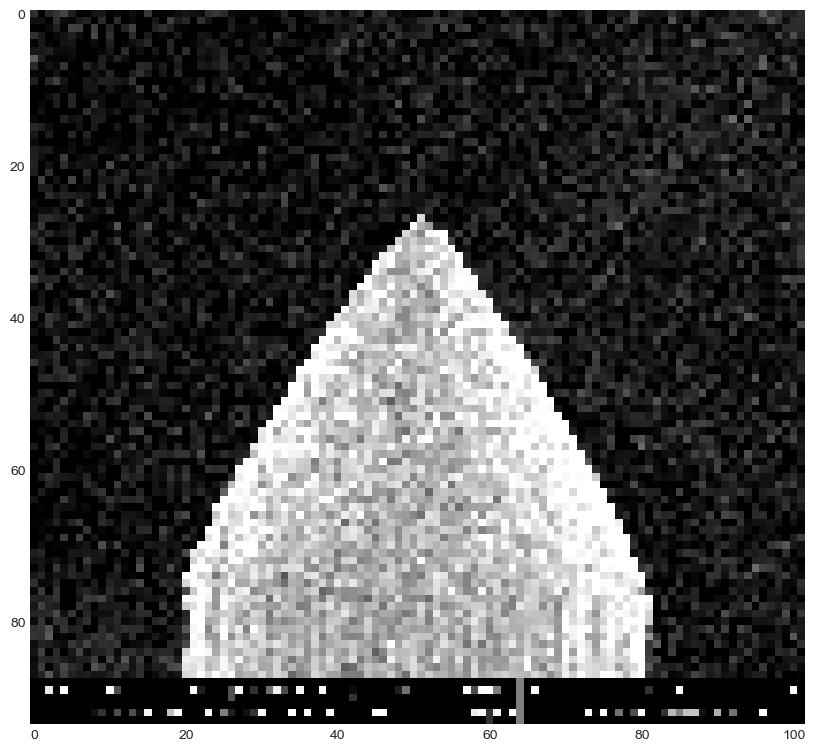

Label: [0. 0. 0. 1. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 21755.2
Image Median Pixel: 12876.0
Image Max Pixel: 65535.0


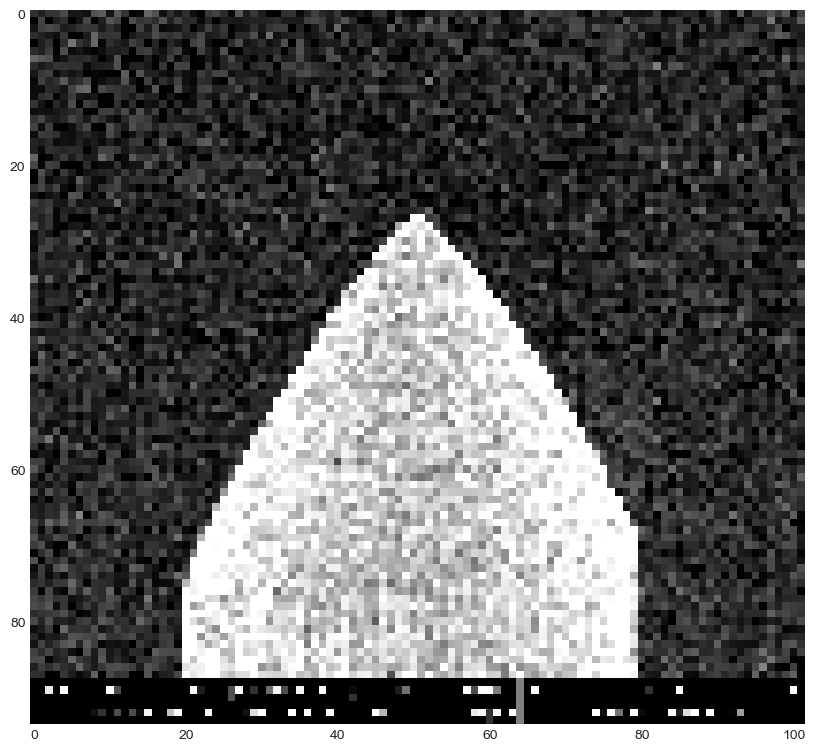

Label: [0. 0. 0. 1. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 17781.2
Image Median Pixel: 1028.0
Image Max Pixel: 65535.0


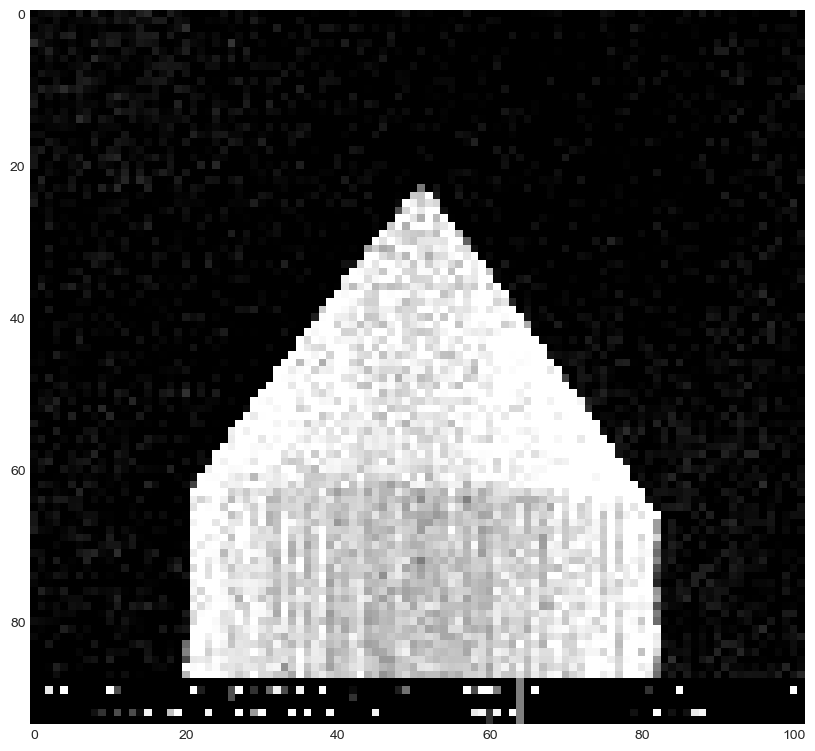

Label: [1. 0. 0. 0. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 16884.8
Image Median Pixel: 10537.0
Image Max Pixel: 65535.0


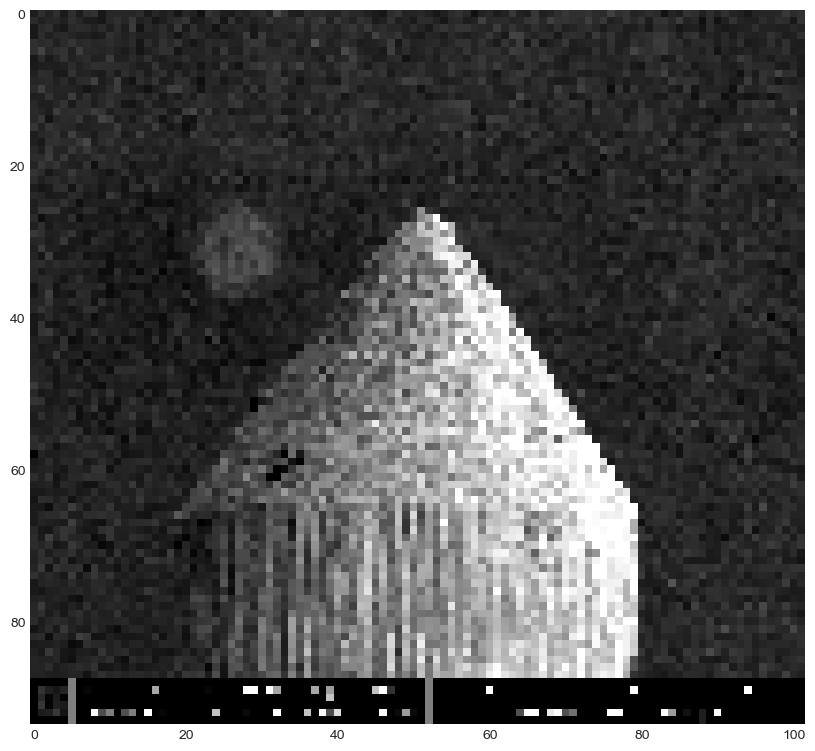

Label: [0. 0. 1. 0. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 16268.1
Image Median Pixel: 2827.0
Image Max Pixel: 65535.0


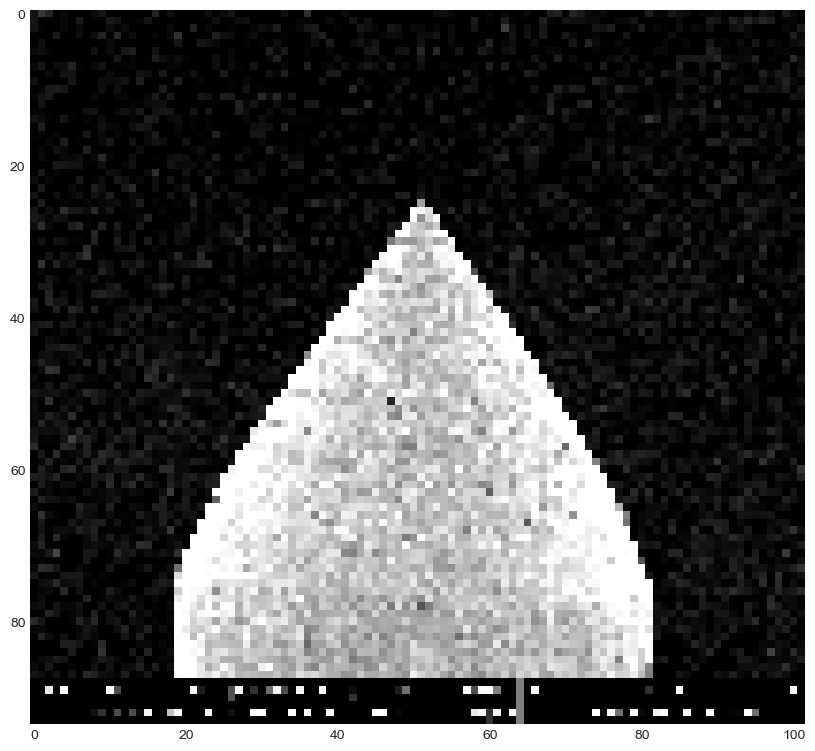

Label: [0. 0. 0. 0. 1.]
Image Min Pixel: 0.0
Image Mean Pixel: 15961.5
Image Median Pixel: 6939.0
Image Max Pixel: 65535.0


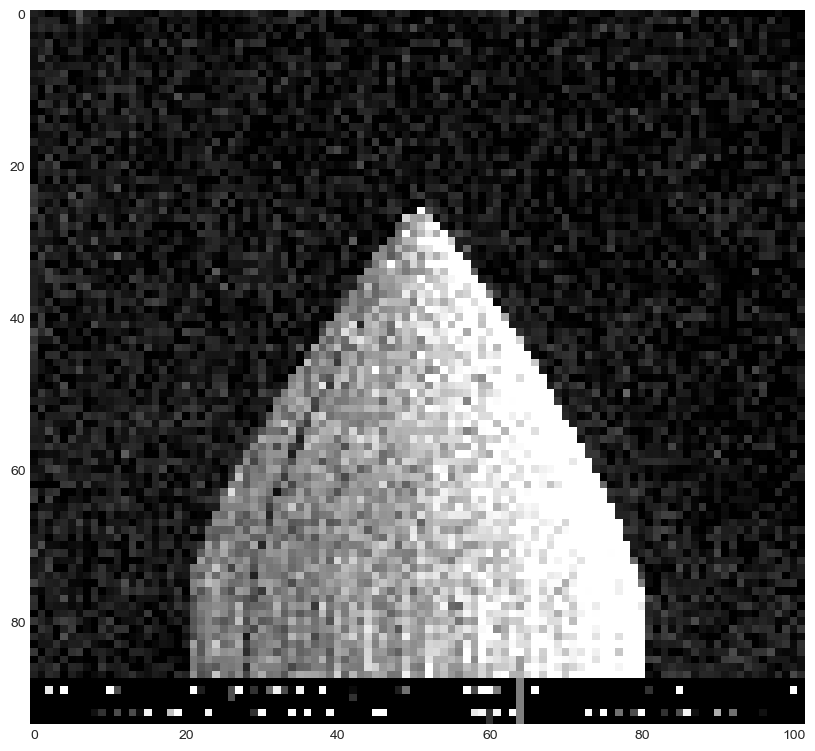

Label: [0. 0. 0. 1. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 21090.9
Image Median Pixel: 11051.0
Image Max Pixel: 65535.0


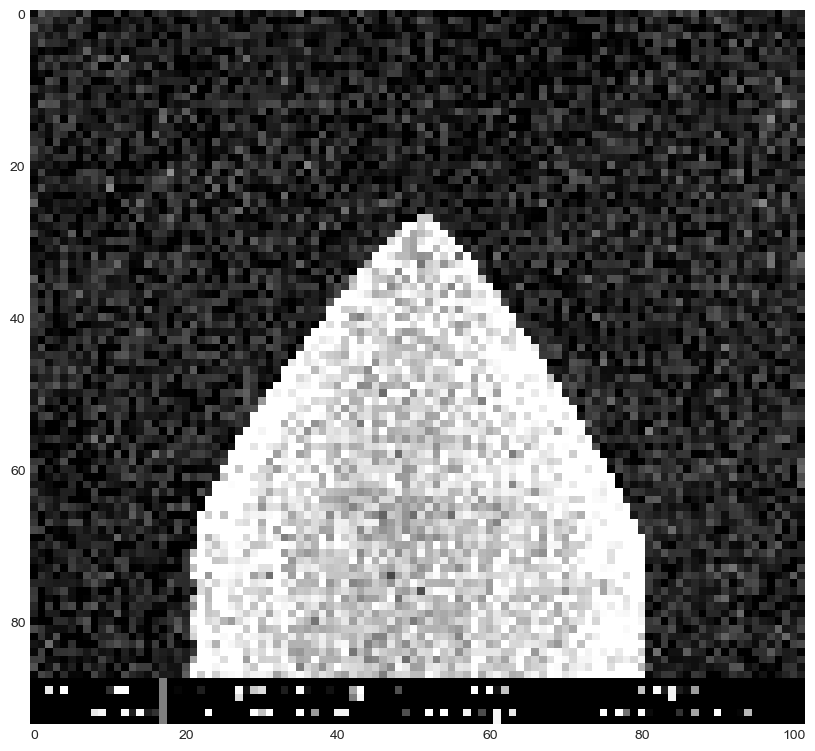

Label: [0. 0. 0. 1. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 25649.5
Image Median Pixel: 14135.0
Image Max Pixel: 65535.0


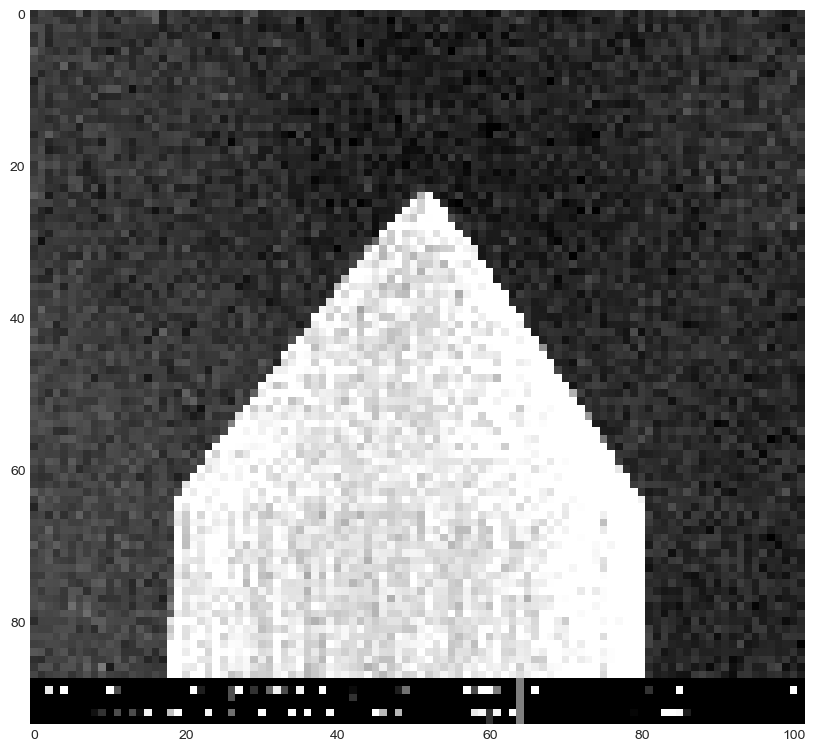

Label: [0. 0. 1. 0. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 17576.7
Image Median Pixel: 6682.0
Image Max Pixel: 65535.0


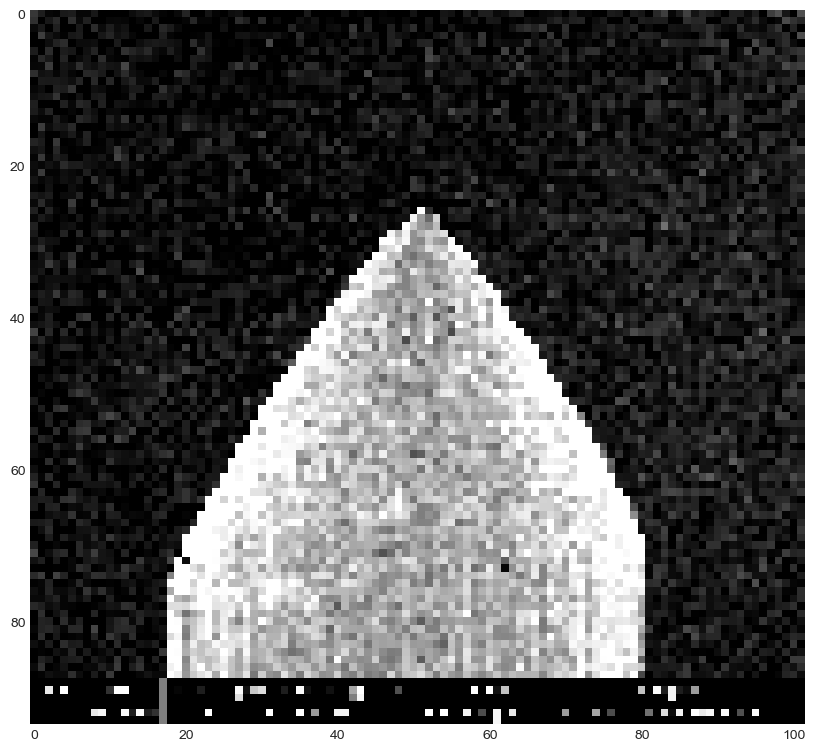

Label: [1. 0. 0. 0. 0.]
Image Min Pixel: 0.0
Image Mean Pixel: 12518.2
Image Median Pixel: 0.0
Image Max Pixel: 65535.0


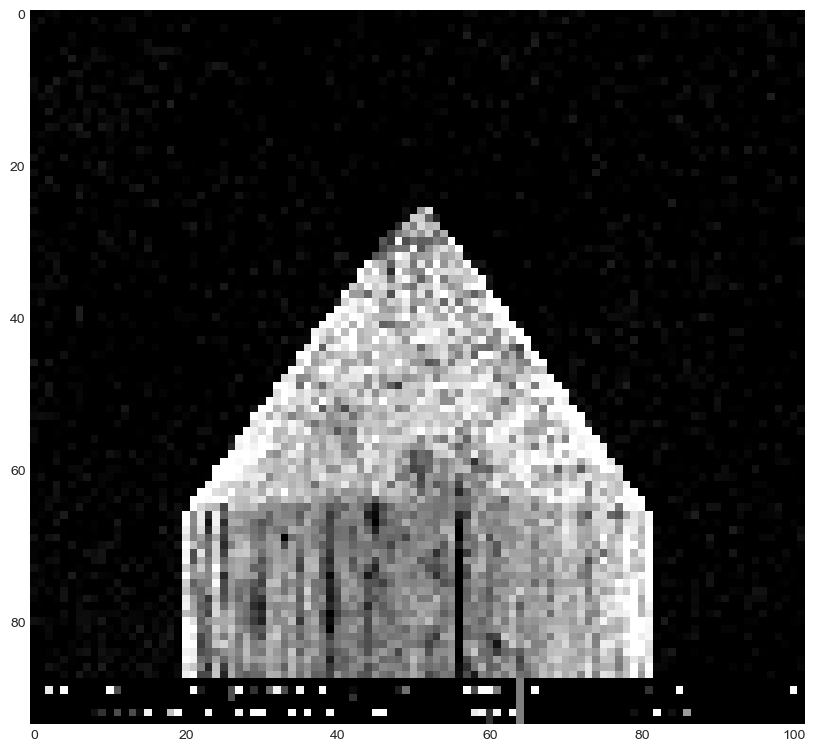

In [4]:
# get the next batch of images
train_images, train_labels = next(train_generator)
# Display the first x images from the training set
for i in np.arange(0, 10):
    print(f'Label: {train_labels[i]}')
    print(f'Image Min Pixel: {train_images[i].min()}')
    print(f'Image Mean Pixel: {train_images[i].mean():.1f}')
    print(f'Image Median Pixel: {np.median(train_images[i])}')
    print(f'Image Max Pixel: {train_images[i].max()}')
    # display the img_cropped image
    plt.imshow(train_images[i], cmap='gray')
    # remove the grid
    plt.grid(False)
    # increase the size of the plot
    plt.gcf().set_size_inches(10, 10)
    plt.show()
    


In [9]:
# get the statistics of the images in the entire dataset
# Get all the data in the directory data/train (790 images), and reshape them
eda_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= (new_height, new_width),
        batch_size=32,
        color_mode='grayscale')

Found 7019 images belonging to 5 classes.


In [10]:
eda_generator.class_indices

{'Contamination': 0, 'Damage': 1, 'Etch': 2, 'PASS': 3, 'Split': 4}

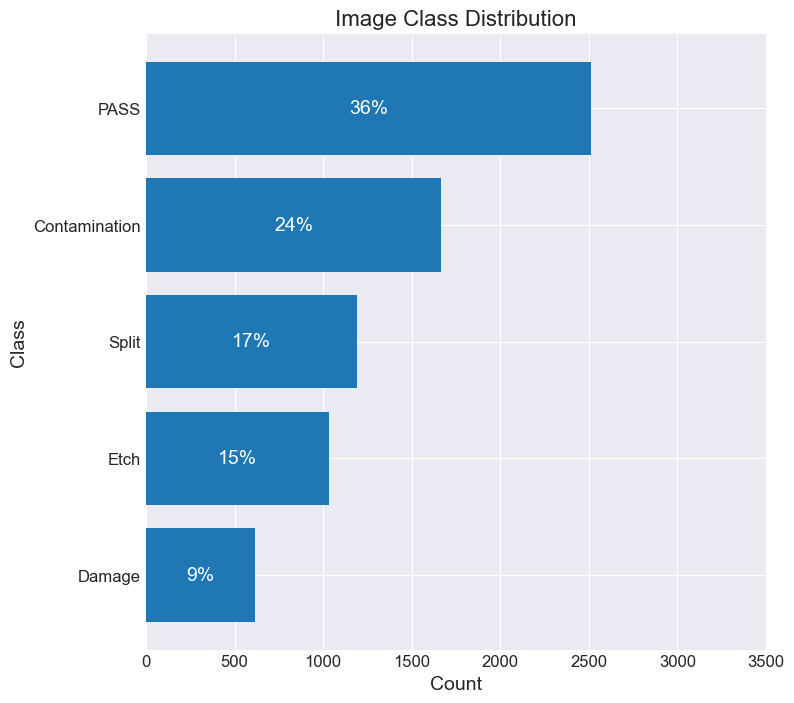

In [11]:
import numpy as np
import matplotlib.pyplot as plt

class_counts = np.bincount(eda_generator.classes)
class_labels = list(eda_generator.class_indices.keys())

# Sort the class labels and counts in descending order
sorted_indices = np.argsort(class_counts)[::-1]
sorted_class_counts = class_counts[sorted_indices]
sorted_class_labels = [class_labels[i] for i in sorted_indices]

# Calculate the percentage of total for each class
total_counts = np.sum(sorted_class_counts)
percentages = (sorted_class_counts / total_counts) * 100

font_size = 14
plt.barh(sorted_class_labels, sorted_class_counts)
plt.xlabel('Count', fontsize=font_size)
plt.ylabel('Class', fontsize=font_size)
plt.title('Image Class Distribution', fontsize=font_size+2)
# set the font size of the x and y ticks
plt.xticks(fontsize=font_size-2)
plt.yticks(fontsize=font_size-2)
plt.gcf().set_size_inches(8, 8)
plt.gca().invert_yaxis()

# Add percentage labels to each bar, centered
for i, (count, percentage) in enumerate(zip(sorted_class_counts, percentages)):
    plt.text(count / 2, i, f'{percentage:.0f}%', 
             va='center', 
             ha='center',
             color='white',
             fontsize=font_size)
    
# make x max 3500 to leave room on the right side of the plot
plt.xlim(0, 3500)



plt.show()



---
### Baseline (Model 0)



In [120]:

data_dir = 'data/raw/images_sorted_multiclass'
original_width = 1024
original_height = 943
scale_factor = 0.1
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)



input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=1, validation_data=validation_generator)

Found 13341 images belonging to 5 classes.
Found 3333 images belonging to 5 classes.
834/834 [==============================] - 153s 183ms/step - loss: 0.7660 - categorical_accuracy: 0.7754 - val_loss: 1.2863 - val_categorical_accuracy: 0.5488


  Training categorical accuracy: 0.7753541469573975
Validation categorical accuracy: 0.548754870891571
               precision    recall  f1-score   support

Contamination       0.10      0.11      0.11       286
 Etch Failure       0.25      0.39      0.30       344
         PASS       0.86      0.69      0.76      2243
    Split Tip       0.00      0.00      0.00       263
   Tip Damage       0.19      0.64      0.29       197

     accuracy                           0.55      3333
    macro avg       0.28      0.37      0.29      3333
 weighted avg       0.63      0.55      0.57      3333



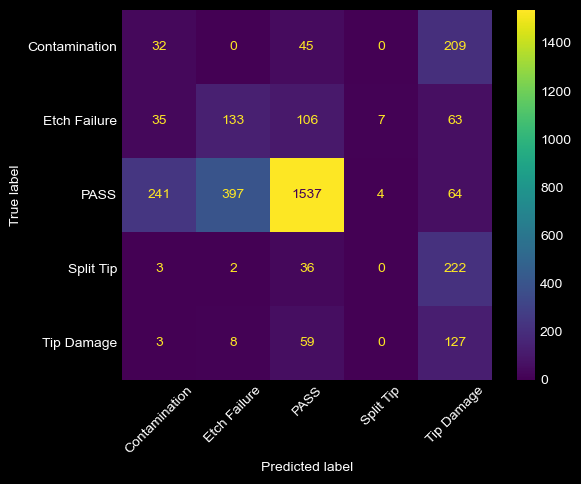

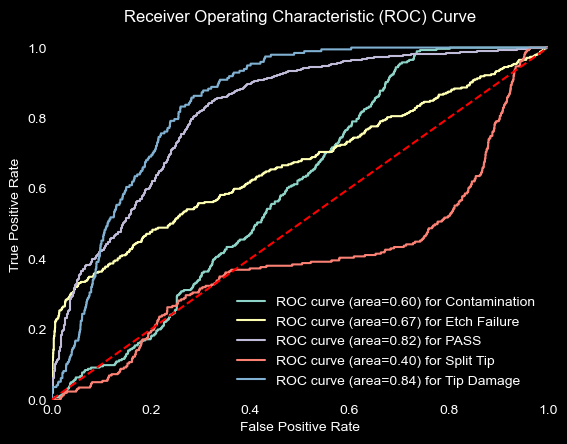

In [134]:
model_results = report_model_performance(model, history, validation_generator)

--> ANALYSIS <---
- Accuracy of 0.67 on the validation is not fantastic considering there is a majority class (which we will need to deal with by applying class weights or undersampling).  Some things we can do to potentially improve accuracy:
    - Increase the scale factor, 0.1 is quite small and only used for running fast models. Probably why we are not catching Split Tip, because the feature is lost when scaled down.
    - Much more re-labeling needs to be done, the labels are quite messy
- Looks like we are overfitting, there is about 10% better accuracy on the training set than the validation set.  
    - We can try dropout and L1 regularization to deal with this.

---
### Model 1
Changes:
- Increased the scale factor to 1.0
    - Reasoning: want to see the difference with just one epoch at full image resolution

In [135]:

num_epochs = 1
scale_factor = 1
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,                          # turning off shuffle for the val set to get consistent reporting
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)


# Define a simple model
input_shape = (target_size[0], target_size[1], 1)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, validation_data=validation_generator)



Found 13341 images belonging to 5 classes.
Found 3333 images belonging to 5 classes.
834/834 [==============================] - 3185s 4s/step - loss: 2.6558 - categorical_accuracy: 0.7531 - val_loss: 1.7140 - val_categorical_accuracy: 0.3819


  Training categorical accuracy: 0.7753541469573975
Validation categorical accuracy: 0.548754870891571
               precision    recall  f1-score   support

Contamination       0.05      0.21      0.08       286
 Etch Failure       0.66      0.32      0.43       344
         PASS       0.85      0.44      0.58      2243
    Split Tip       0.01      0.01      0.01       263
   Tip Damage       0.20      0.56      0.30       197

     accuracy                           0.38      3333
    macro avg       0.35      0.31      0.28      3333
 weighted avg       0.66      0.38      0.46      3333



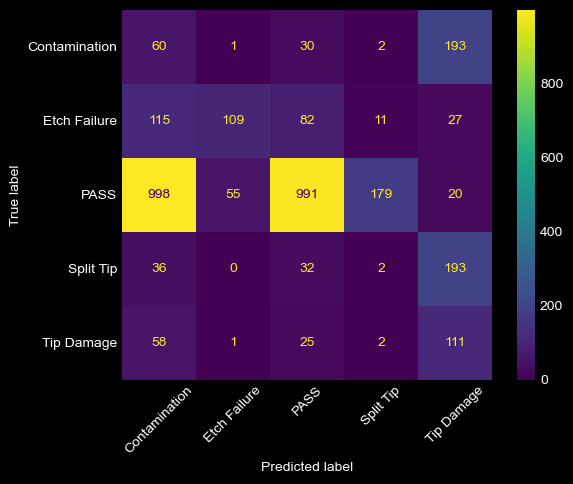

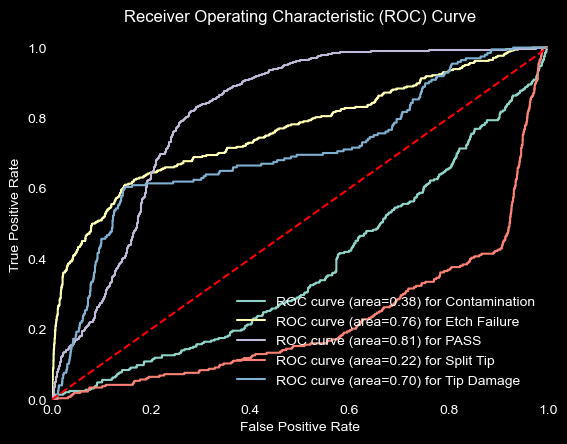

In [136]:
model_results = report_model_performance(model, history, validation_generator)

In [149]:
# Display the model results sorted by validation accuracy
model_results_df.sort_values(by='Val Accuracy', ascending=False)

,Model,Train Accuracy,Val Accuracy
0,Model 2,0.786037,0.690141
1,Baseline (Model 0),0.775354,0.548755
2,Model 1,0.753100,0.381900


--> ANALYSIS <---
- Interesting that we did so much worse by increasing the resolution scale to 1.0.  
    - Need more training?
    - Need to correct labels?

---
### Model 2
Changes:
- Removed incorrectly classified images from the Contamination folder
- Reduced the quantity of images in the PASS folder to better balance the targets

In [139]:
get_folder_counts()

Class: Contamination - 1094 files
Class: Etch Failure - 1724 files
Class: PASS - 1800 files
Class: Split Tip - 1321 files
Class: Tip Damage - 988 files


In [153]:

num_epochs = 1
scale_factor = 0.1
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)



input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, validation_data=validation_generator)

Found 5544 images belonging to 5 classes.
Found 1382 images belonging to 5 classes.
347/347 [==============================] - 65s 186ms/step - loss: 0.9403 - categorical_accuracy: 0.6768 - val_loss: 1.7536 - val_categorical_accuracy: 0.3256


  Training categorical accuracy: 0.6767676472663879
Validation categorical accuracy: 0.3256150484085083
Number of predictions: 1382
               precision    recall  f1-score   support

Contamination       0.42      0.22      0.28       218
 Etch Failure       0.92      0.22      0.36       344
         PASS       0.53      0.46      0.49       359
    Split Tip       0.08      0.08      0.08       264
   Tip Damage       0.22      0.71      0.34       197

     accuracy                           0.33      1382
    macro avg       0.43      0.34      0.31      1382
 weighted avg       0.48      0.33      0.33      1382



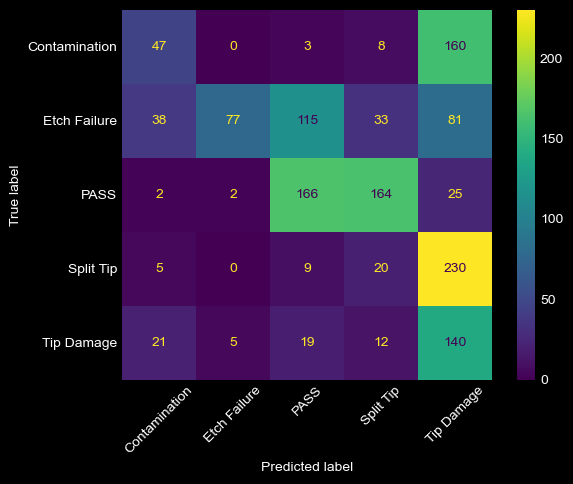

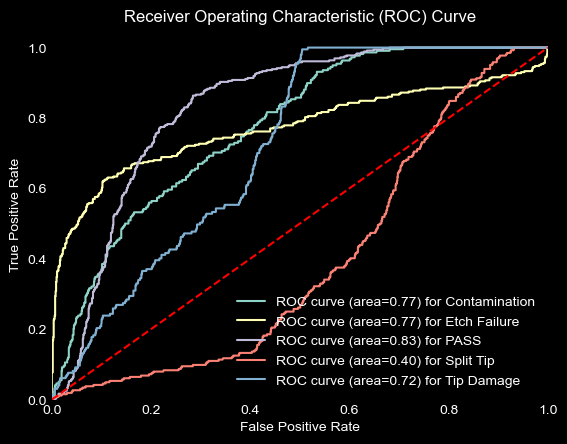

In [154]:
report_model_performance('Model 2', model, history, validation_generator)

In [164]:
# Display the model results sorted by validation accuracy
model_results_df.sort_values(by='Val Accuracy', ascending=False)

,Model,Train Accuracy,Val Accuracy
0,Model 3,0.713925,0.426918


--> ANALYSIS <---
- The results are more realistic now that the classes are more even.
- Not sure about the disparity between training and validation, I guess regularization is needed.  Surprising to be over fitted after only 1 epoch
- Getting a little better result from contamination, need to see whats going on in the tip damage folder, may be a lot of true contam in there
- Curious we are doing so well in Etch Failure, need to look at those images
- Split tip may not do well at such low resolution scaling because the feature is more difficult to discern


---
### Model 3
Changes:
- Adding dropout regularization after the convolutions at 0.5 rate
- Adding a second layer of Convolution with 3x3 kernel and 64 filters
- Increasing scale factor to 0.25

In [183]:
get_folder_counts()

Class: Contamination - 1161 files
Class: Etch Failure - 1724 files
Class: PASS - 1499 files
Class: Split Tip - 1323 files
Class: Tip Damage - 989 files


In [160]:

num_epochs = 3
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)



input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, validation_data=validation_generator)

Found 5544 images belonging to 5 classes.
Found 1382 images belonging to 5 classes.
Epoch 1/3
347/347 [==============================] - 303s 872ms/step - loss: 1.2529 - categorical_accuracy: 0.5583 - val_loss: 1.6338 - val_categorical_accuracy: 0.3857
Epoch 2/3
347/347 [==============================] - 296s 854ms/step - loss: 0.9053 - categorical_accuracy: 0.6831 - val_loss: 1.7138 - val_categorical_accuracy: 0.4074
Epoch 3/3
347/347 [==============================] - 306s 881ms/step - loss: 0.8112 - categorical_accuracy: 0.7139 - val_loss: 1.8917 - val_categorical_accuracy: 0.4269


  Training categorical accuracy: 0.7139249444007874
Validation categorical accuracy: 0.42691752314567566
Number of predictions: 1382
               precision    recall  f1-score   support

Contamination       0.36      0.18      0.24       218
 Etch Failure       0.82      0.22      0.35       344
         PASS       0.58      0.96      0.73       359
    Split Tip       0.12      0.01      0.02       264
   Tip Damage       0.22      0.64      0.33       197

     accuracy                           0.43      1382
    macro avg       0.42      0.40      0.33      1382
 weighted avg       0.47      0.43      0.36      1382



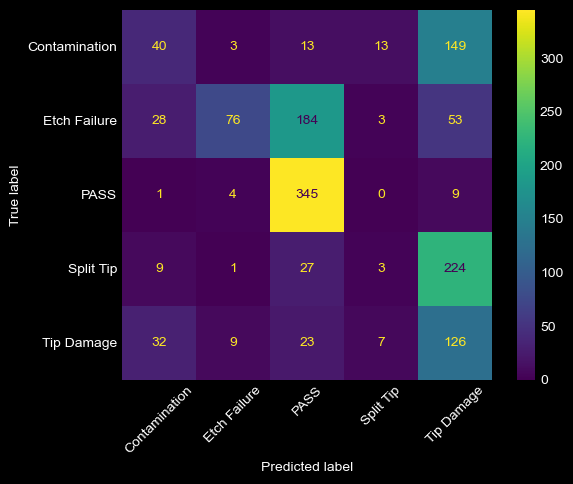

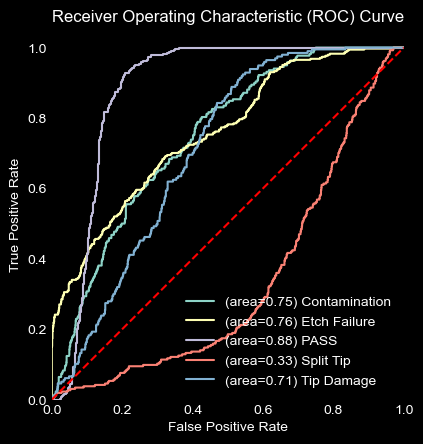

In [166]:
report_model_performance('Model 3', model, history, validation_generator)

In [165]:
# Display the model results sorted by validation accuracy
model_results_df.sort_values(by='Val Accuracy', ascending=False)

,Model,Train Accuracy,Val Accuracy
0,Model 3,0.713925,0.426918


--> ANALYSIS <---
- Modest improvement in accuracy, however still overfitting.
- Far fewer false positives for PASS now.  
- Probably all moot until I get the labels fixed.



---
### Model 4
Changes:
- Blacking out the footer to eliminate any inforation the model might be training there
    - Note: optimally I would just remove the footer rows from the image during pre-process, but I haven't been able to get this to work with the ImageDataGenerator because it changes the target size and it throws an error.

In [172]:
# create a function to change the pixel value of the bottom 60 rows of an image to 0
def blackout_footer(image):
    image[-60:, :] = 0
    return image

In [180]:

num_epochs = 3
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2) #, preprocessing_function=blackout_footer)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)


input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, validation_data=validation_generator)

Found 5544 images belonging to 5 classes.
Found 1382 images belonging to 5 classes.
Epoch 1/3
347/347 [==============================] - 315s 909ms/step - loss: 1.2632 - categorical_accuracy: 0.5651 - val_loss: 1.7261 - val_categorical_accuracy: 0.3893
Epoch 2/3
347/347 [==============================] - 318s 916ms/step - loss: 0.8819 - categorical_accuracy: 0.7063 - val_loss: 1.8540 - val_categorical_accuracy: 0.4247
Epoch 3/3
347/347 [==============================] - 327s 941ms/step - loss: 0.8014 - categorical_accuracy: 0.7307 - val_loss: 2.3720 - val_categorical_accuracy: 0.4081


  Training categorical accuracy: 0.7306998372077942
Validation categorical accuracy: 0.40810421109199524
Number of predictions: 1382
               precision    recall  f1-score   support

Contamination       0.31      0.26      0.28       218
 Etch Failure       0.89      0.25      0.39       344
         PASS       0.65      0.80      0.72       359
    Split Tip       0.12      0.05      0.07       264
   Tip Damage       0.22      0.62      0.33       197

     accuracy                           0.41      1382
    macro avg       0.44      0.40      0.36      1382
 weighted avg       0.49      0.41      0.39      1382



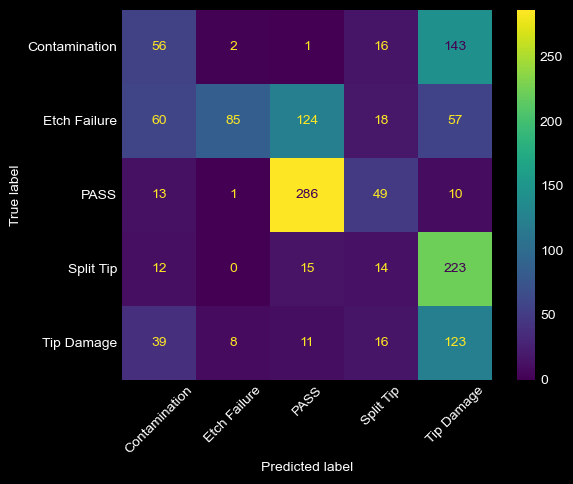

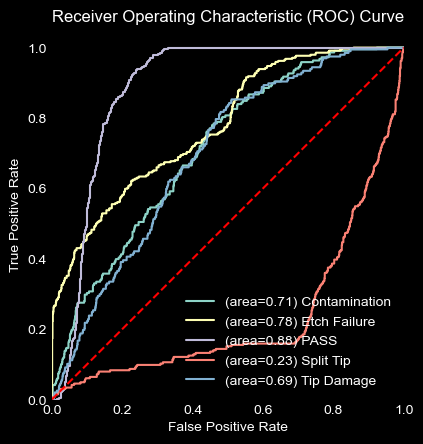

In [181]:
report_model_performance('Model 4', model, history, validation_generator)

In [182]:
# Display the model results sorted by validation accuracy
model_results_df.sort_values(by='Val Accuracy', ascending=False)

,Model,Train Accuracy,Val Accuracy
0,Model 3,0.713925,0.426918
1,Model 4,0.730700,0.408104


--> ANALYSIS <---
- Model 4 is the same as Model 3. Originally I ran Model 4 with the blackout_footer function (which I tested visually ok far above), and for some reason it sent most of the PASS images into Split Tip.  I don't understand this at all, my first thought is that it shifted the labels somehow for the confusion matrix, but it only effected the PASS class.
- Need to investigate a better method for removing the footer, and do need to remove the footer.
- STILL NEED TO FIX ALL THE LABELS!!!


---
### Model 5
Changes:
- Attempting the crop footer function again using crop_footer_and_resize

In [271]:


num_epochs = 10
original_width = 1024
original_height = 943
scale_factor = 1
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator with rescaling and the custom preprocessing function
datagen = ImageDataGenerator(rescale=1./65535, validation_split=0.2, preprocessing_function=crop_footer_and_resize)

# create the train generator
train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='categorical',
        seed=42)

# create the validation generator
validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='categorical',
        seed=42)


input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),   # padding
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),       # more dense
    Dropout(0.5),                   # move up
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3)#, restore_best_weights=True)

# Calculate steps per epoch
steps_per_epoch = len(train_generator)

# Train the model using the generators
model5_trained = True
if model5_trained:
    model = joblib.load('Models\\model_5.pkl')
else:
        history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs,
                        validation_data=validation_generator,
                        callbacks=[early_stopping])

Found 5355 images belonging to 5 classes.
Found 1335 images belonging to 5 classes.
Epoch 1/10
335/335 [==============================] - 2349s 7s/step - loss: 2.9118 - categorical_accuracy: 0.4788 - val_loss: 1.6475 - val_categorical_accuracy: 0.3004
Epoch 2/10
335/335 [==============================] - 2337s 7s/step - loss: 0.9376 - categorical_accuracy: 0.6697 - val_loss: 1.7703 - val_categorical_accuracy: 0.3184
Epoch 3/10
335/335 [==============================] - 2330s 7s/step - loss: 0.7660 - categorical_accuracy: 0.7300 - val_loss: 2.0397 - val_categorical_accuracy: 0.3363
Epoch 4/10
335/335 [==============================] - 2333s 7s/step - loss: 0.5802 - categorical_accuracy: 0.7965 - val_loss: 1.9335 - val_categorical_accuracy: 0.3438
Epoch 5/10
335/335 [==============================] - 2344s 7s/step - loss: 0.4133 - categorical_accuracy: 0.8551 - val_loss: 2.6148 - val_categorical_accuracy: 0.3236
Epoch 6/10
335/335 [==============================] - 2332s 7s/step - loss: 

In [273]:

if not model5_trained:
    joblib.dump(model, 'Models\\model_5.pkl')


INFO:tensorflow:Assets written to: ram://5452db82-35ee-49d3-8241-ca77b52ea60c/assets


['Models\\model_5.pkl']

  Training categorical accuracy: 0.9159663915634155
Validation categorical accuracy: 0.31910112500190735
Number of predictions: 1335
               precision    recall  f1-score   support

Contamination       0.43      0.47      0.45       242
 Etch Failure       0.79      0.39      0.52       342
         PASS       0.22      0.08      0.12       299
    Split Tip       0.12      0.18      0.15       266
   Tip Damage       0.26      0.58      0.36       186

     accuracy                           0.32      1335
    macro avg       0.37      0.34      0.32      1335
 weighted avg       0.39      0.32      0.32      1335



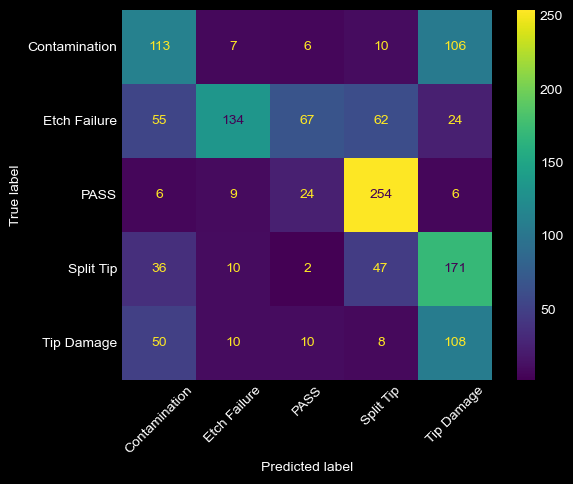

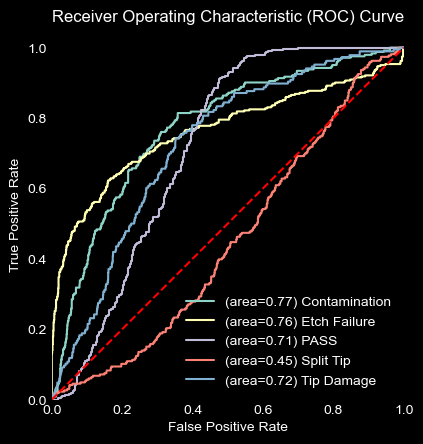

In [274]:
report_model_performance('Model 5', model, history, validation_generator)

In [ ]:
# Display the model results sorted by validation accuracy
model_results_df.sort_values(by='Val Accuracy', ascending=False)

,Model,Train Accuracy,Val Accuracy
0,Model 3,0.713925,0.426918
1,Model 4,0.730700,0.408104


--> ANALYSIS <---
- Model 5 is still overfitting and not performing well.
- Cause for the shift in pass to split tip when removing the footer is still unknown, going to backburner for now

---
### Model 6
Changes:
- Going to simplify to only PASS and Contamination as those labels have been cleaned and the signal should be strong
- Leaving out cropping
- Adding more dense layers and batch normalization
- Changing the output to binary, signmoid
- Changed to steps_per_epoch = train_generator.samples // train_generator.batch_size to fully use all training data
- Added data augmentation in the ImageDataGenerator; horizontal_flip, zoom_range, height_shift_range

In [436]:
# change the data directory since we are doing binary classification
data_dir = 'data/raw/images_sorted_binary'
# check the image counts
get_folder_counts(data_dir)

Class: Contamination - 1215 files
Class: PASS - 1499 files


In [469]:

num_epochs = 50
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535, 
                                   validation_split=0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Create an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535, 
                                 validation_split=0.2)


# create the train generator
train_generator = train_datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='binary',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        data_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='binary',
        seed=42
)


input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='Models\model6_epoch_{epoch:02d}.h5',  # Save the model with the epoch number in the filename
    save_weights_only=False,  # Save the full model (architecture + weights)
    save_freq='epoch'  # Save the model at the end of each epoch
)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Train the model using the generators
model6_trained = False
if model6_trained:
    model = joblib.load('Models\\model_6.pkl')
else:
        history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs,
                        validation_data=validation_generator,
                        callbacks=[checkpoint, early_stopping])

Found 2172 images belonging to 2 classes.
Found 542 images belonging to 2 classes.
Epoch 1/50
135/135 [==============================] - 224s 2s/step - loss: 0.5158 - accuracy: 0.7583 - val_loss: 2.6308 - val_accuracy: 0.4483
Epoch 2/50
135/135 [==============================] - 225s 2s/step - loss: 0.4089 - accuracy: 0.8210 - val_loss: 2.1995 - val_accuracy: 0.4483
Epoch 3/50
135/135 [==============================] - 230s 2s/step - loss: 0.3899 - accuracy: 0.8321 - val_loss: 1.1622 - val_accuracy: 0.4483
Epoch 4/50
135/135 [==============================] - 218s 2s/step - loss: 0.3612 - accuracy: 0.8442 - val_loss: 3.2399 - val_accuracy: 0.4483
Epoch 5/50
135/135 [==============================] - 217s 2s/step - loss: 0.3503 - accuracy: 0.8576 - val_loss: 0.1860 - val_accuracy: 0.9336
Epoch 6/50
135/135 [==============================] - 216s 2s/step - loss: 0.3424 - accuracy: 0.8618 - val_loss: 3.2267 - val_accuracy: 0.4502
Epoch 7/50
135/135 [==============================] - 216s 

In [470]:

if not model6_trained:
    joblib.dump(model, 'Models\\model_6.pkl')


INFO:tensorflow:Assets written to: ram://0611b9b5-ae53-4300-a936-2bd4cd34797d/assets


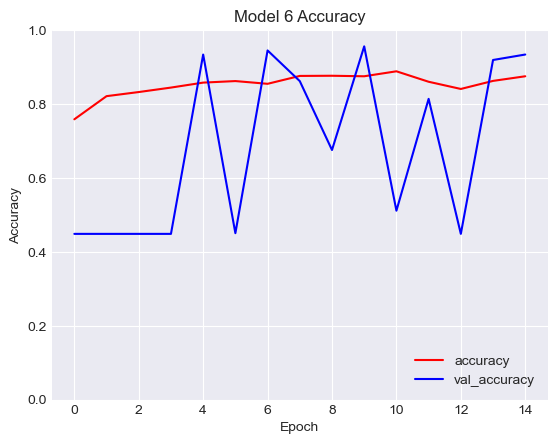

In [494]:
# Display a graph of accuracy for the training and validation sets by epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

# add title and labels
plt.title('Model 6 Accuracy')
# change the line colors
plt.gca().get_lines()[0].set_color('red')
plt.gca().get_lines()[1].set_color('blue')
plt.legend(loc='lower right')
plt.show()


In [486]:
# find the index of the best val_accuracy in the history
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy_index = history.history['val_accuracy'].index(best_val_accuracy)
# get the training accuracy at the best val_accuracy
best_train_accuracy = history.history['accuracy'][best_val_accuracy_index]
print(f'  Best Training Accuracy: {best_train_accuracy}')
print(f'Best Validation Accuracy: {best_val_accuracy}')


  Best Training Accuracy: 0.874768078327179
Best Validation Accuracy: 0.955719530582428


In [481]:
# calculate the validation accuracy
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy}')

34/34 [==============================] - 11s 335ms/step - loss: 0.1394 - accuracy: 0.9557
Validation Accuracy: 0.955719530582428


  Training Accuracy: 0.874768078327179
Validation Accuracy: 0.9335793256759644
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       243
           1       1.00      0.92      0.96       299

    accuracy                           0.96       542
   macro avg       0.96      0.96      0.96       542
weighted avg       0.96      0.96      0.96       542



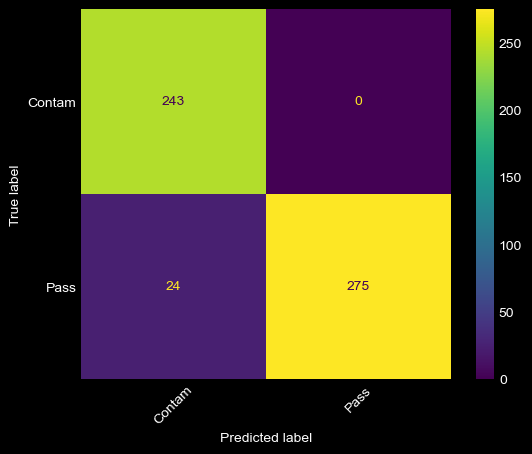

In [474]:
# create a confustion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the classes of the training images
train_pred = model.predict(train_generator)
# Get the predicted classes
train_pred_classes = (train_pred > 0.5).astype(int)
# Predict the classes of the images
val_pred = model.predict(validation_generator)

# Get the true validation classes
true_classes = validation_generator.classes
# print the training accuracy
print('='*50)
print(f'  Training Accuracy: {history.history["accuracy"][-1]:.3f}')
# print the validation accuracy
print(f'Validation Accuracy: {history.history["val_accuracy"][-1]:.3f}')
print('='*50)
# Generate a classification report
report = classification_report(true_classes, predicted_classes)
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Contam', 'Pass'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

In [ ]:
# Display the model results sorted by validation accuracy
model_results_df.sort_values(by='Val Accuracy', ascending=False)

--> ANALYSIS Model 6 <---
- Much improved result!  This is an MVP.  Zero false positives for PASS class which is what we are wanting
- Still concerned about the jerkiness of the validation set from epoch to epoch

---
### Model 7
Changes:
- Adding a test set

In [519]:
# change the data directory since we are doing binary classification
data_dir = 'data/raw/images_sorted_binary/Train_val'
# check the image counts
get_folder_counts(data_dir)

Class: Contamination - 1033 files
Class: PASS - 1275 files


In [520]:
# change the data directory since we are doing binary classification
data_dir = 'data/raw/images_sorted_binary/Test'
# check the image counts
get_folder_counts(data_dir)

Class: Contamination - 182 files
Class: PASS - 224 files


In [546]:
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 1
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Create an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535, 
                                   validation_split=0.15,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Create an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535, 
                                 validation_split=0.15)

# create the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# the train images directory
train_dir = 'data/raw/images_sorted_binary/Train_val'
# the test images directory
test_dir = 'data/raw/images_sorted_binary/Test'

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        subset='training',
        class_mode='binary',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        train_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='validation',
        class_mode='binary',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size=target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        class_mode='binary',
        seed=42
)


input_shape = (target_size[0], target_size[1], 1)
# Define a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

#from tensorflow.keras.callbacks import ModelCheckpoint

# # Define the ModelCheckpoint callback
# checkpoint = ModelCheckpoint(
#     filepath='Models\model7_epoch_{epoch:02d}.h5',  # Save the model with the epoch number in the filename
#     save_weights_only=True,  # Save the full model (architecture + weights)
#     save_freq='epoch'  # Save the model at the end of each epoch
# )


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size


history = model.fit(train_generator, 
                steps_per_epoch=steps_per_epoch, 
                epochs=num_epochs,
                validation_data=validation_generator,
                callbacks=[early_stopping])

# Pickle the best model
joblib.dump(model, 'Models\\model_7.pkl')

Found 1963 images belonging to 2 classes.
Found 345 images belonging to 2 classes.
Found 406 images belonging to 2 classes.
Epoch 1/100
122/122 [==============================] - 1526s 12s/step - loss: 0.5290 - accuracy: 0.7560 - val_loss: 1.9777 - val_accuracy: 0.4464
Epoch 2/100
122/122 [==============================] - 1473s 12s/step - loss: 0.4661 - accuracy: 0.7879 - val_loss: 2.2486 - val_accuracy: 0.4464
Epoch 3/100
122/122 [==============================] - 1441s 12s/step - loss: 0.4219 - accuracy: 0.8079 - val_loss: 2.2633 - val_accuracy: 0.4464
Epoch 4/100
122/122 [==============================] - 1432s 12s/step - loss: 0.4058 - accuracy: 0.8264 - val_loss: 0.7804 - val_accuracy: 0.5217
Epoch 5/100
122/122 [==============================] - 1501s 12s/step - loss: 0.3750 - accuracy: 0.8480 - val_loss: 0.6624 - val_accuracy: 0.7420
Epoch 6/100
122/122 [==============================] - 1467s 12s/step - loss: 0.4127 - accuracy: 0.8269 - val_loss: 1.4927 - val_accuracy: 0.4522


['Models\\model_7.pkl']

In [547]:
# get the results of the test set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

22/22 [==============================] - 56s 3s/step - loss: 0.0830 - accuracy: 0.9768
Validation Loss: 0.08298756927251816
Validation Accuracy: 0.9768115878105164


In [548]:
# get the results of the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

26/26 [==============================] - 62s 2s/step - loss: 0.2656 - accuracy: 0.8941
Test Loss: 0.2655832767486572
Test Accuracy: 0.8940886855125427


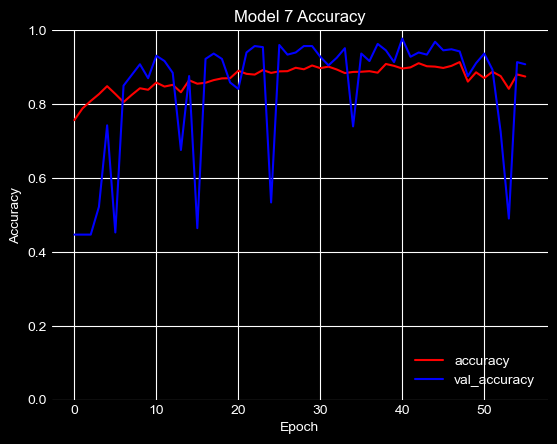

In [549]:
# Display a graph of accuracy for the training and validation sets by epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

# add title and labels
plt.title('Model 7 Accuracy')
# change the line colors
plt.gca().get_lines()[0].set_color('red')
plt.gca().get_lines()[1].set_color('blue')
plt.legend(loc='lower right')
plt.show()


  Training Accuracy: 0.896
Validation Accuracy: 0.977
      Test Accuracy: 0.894
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       182
           1       0.84      1.00      0.91       224

    accuracy                           0.89       406
   macro avg       0.92      0.88      0.89       406
weighted avg       0.91      0.89      0.89       406



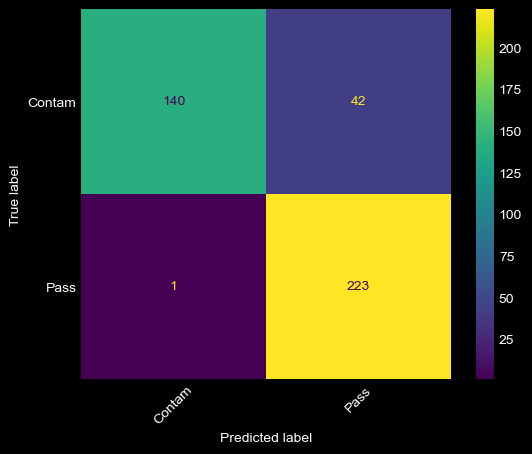

In [550]:
# create a confustion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the classes of the test images
test_pred = model.predict(test_generator)
# Get the predicted classes
test_pred_classes = (test_pred > 0.5).astype(int)

# find the index of the best val_accuracy in the history
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy_index = history.history['val_accuracy'].index(best_val_accuracy)
# get the training accuracy at the best val_accuracy
best_train_accuracy = history.history['accuracy'][best_val_accuracy_index]
# print the training accuracy
print('='*50)
print(f'  Training Accuracy: {best_train_accuracy:.3f}')
# print the validation accuracy
print(f'Validation Accuracy: {best_val_accuracy:.3f}')
# print the test accuracy
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f'      Test Accuracy: {test_accuracy:.3f}')
print('='*50)


# Get the true test classes
true_classes = test_generator.classes
# Generate a classification report
report = classification_report(true_classes, test_pred_classes)
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(true_classes, test_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Contam', 'Pass'])
# dark background
plt.style.use('dark_background')
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


In [582]:
# Create a ROC Curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Predict the classes of the test images
y_test_prob = model.predict(test_generator)
# Get the true test classes
y_test_true = test_generator.classes

# Predict the classes of the training images
y_val_prob = model.predict(validation_generator)
# Get the predicted classes
y_val_true = validation_generator.classes

# Create the ROC curve plot for both the training and test data
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_prob)
fpr_val, tpr_val, _ = roc_curve(y_val_true, y_val_prob)
plt.figure(figsize=(6, 5.5))
plt.plot(fpr_test, tpr_test, label='Test Data')
plt.plot(fpr_val, tpr_val, label='Train Data')
plt.plot([0, 1], [0, 1], 'k--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/images_sorted_binary/Test\\Contamination\\178229.tif'

In [ ]:
# Display the model results sorted by validation accuracy
model_results_df.sort_values(by='Val Accuracy', ascending=False)

--> ANALYSIS Model 7 <---
- We introduced a completely unseen test set in this model. Overall the performance improvement, if any, was dubious given it took 22hr to run the model on the full size images.  Reducing the image size doesn't seem to have that great of an effect on performance vs how much extra time it takes to run the model.
- Should be getting better results.  Going to try adding more convolution layers.

---
### Model 8
Changes:
- Created a different folder for train, val, test splits
- Adding 2 additionaly convolution layers
- Increased the number of nodes in the first two dense layers
- Changed from flatten() after the convolutions to GlobalAveragePooling2D() to help generalization
- Added class weights

In [7]:
model_name = 'Model_8'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.5
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535, 
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=True,
        color_mode='grayscale',
        class_mode='binary',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        class_mode='binary',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size=target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        class_mode='binary',
        seed=42
)

# import global_average_pooling2d
from tensorflow.keras.layers import GlobalAveragePooling2D

# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
#     Conv2D(256, (3, 3), activation='relu', padding='valid'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
    Flatten(),
#     GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(train_generator.classes), 
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# fit the model
history = model.fit(train_generator, 
                steps_per_epoch=steps_per_epoch, 
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])

# Pickle the model
pkl_path = f'Models\\{model_name}.pkl'
joblib.dump(model, pkl_path)

Found 1902 images belonging to 2 classes.
Found 406 images belonging to 2 classes.
Found 406 images belonging to 2 classes.
Epoch 1/100
  5/118 [>.............................] - ETA: 8:06 - loss: 1.2464 - accuracy: 0.5250

KeyboardInterrupt: 

In [26]:
# get the results of the test set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

26/26 [==============================] - 19s 726ms/step - loss: 0.4234 - accuracy: 0.8300
Validation Loss: 0.4233759641647339
Validation Accuracy: 0.8300492763519287


In [27]:
# get the results of the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

26/26 [==============================] - 20s 770ms/step - loss: 0.4106 - accuracy: 0.8276
Test Loss: 0.4105803370475769
Test Accuracy: 0.8275862336158752


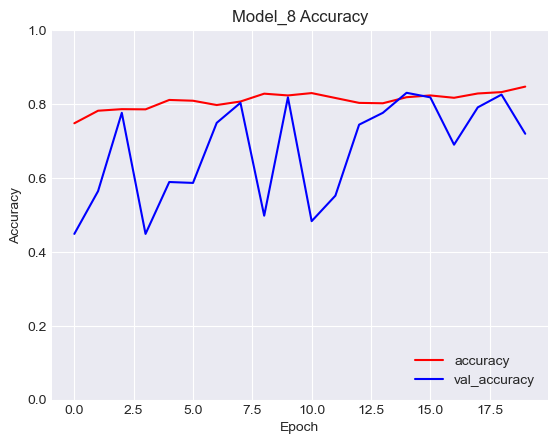

In [28]:
# Display a graph of accuracy for the training and validation sets by epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

# add title and labels
plt.title(f'{model_name} Accuracy')
# change the line colors
plt.gca().get_lines()[0].set_color('red')
plt.gca().get_lines()[1].set_color('blue')
plt.legend(loc='lower right')
plt.show()


  Training Accuracy: 0.818
Validation Accuracy: 0.830
      Test Accuracy: 0.828
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       182
           1       0.80      0.92      0.85       224

    accuracy                           0.83       406
   macro avg       0.84      0.82      0.82       406
weighted avg       0.83      0.83      0.83       406



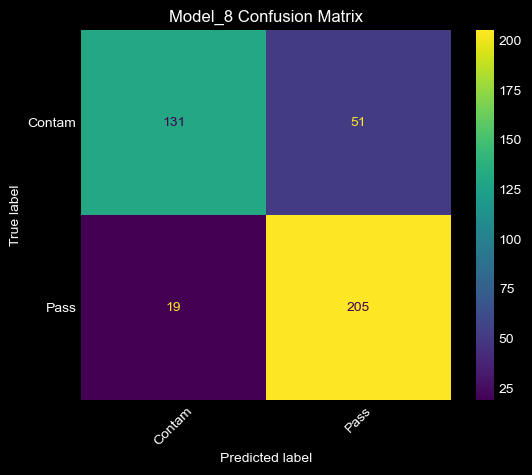

In [41]:


# Predict the classes of the test images
y_test_prob = model.predict(test_generator)
# Get the predicted classes
test_pred_classes = (test_pred > 0.5).astype(int)

# find the index of the best val_accuracy in the history
best_val_accuracy = max(history.history['val_accuracy'])
best_val_accuracy_index = history.history['val_accuracy'].index(best_val_accuracy)
# get the training accuracy at the best val_accuracy
best_train_accuracy = history.history['accuracy'][best_val_accuracy_index]
# print the training accuracy
print('='*50)
print(f'  Training Accuracy: {best_train_accuracy:.3f}')
# print the validation accuracy
print(f'Validation Accuracy: {best_val_accuracy:.3f}')
# print the test accuracy
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f'      Test Accuracy: {test_accuracy:.3f}')
print('='*50)


# Get the true test classes
y_test_true = test_generator.classes
# Generate a classification report
report = classification_report(true_classes, test_pred_classes)
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(true_classes, test_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Contam', 'Pass'])
# dark background
plt.style.use('dark_background')
disp.plot()
plt.title(f'{model_name} Confusion Matrix')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


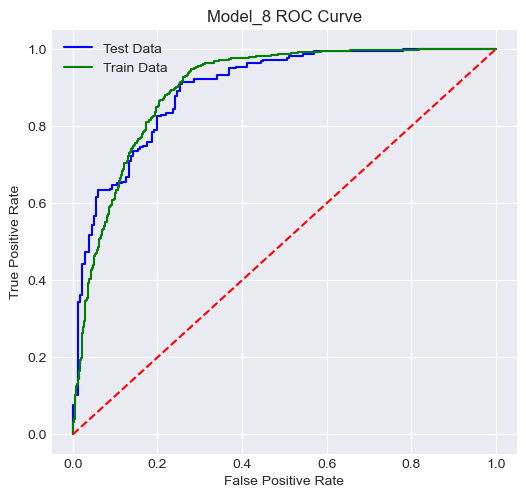

In [40]:
# Create an ImageDataGenerator for the training set without augmentations
train_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator that doesn't shuffle
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= target_size,
        batch_size=16, 
        shuffle=False,
        color_mode='grayscale',
        subset='training',
        class_mode='binary'
)

# Predict the classes of the training images
y_train_prob = model.predict(train_generator)
# Get the predicted classes
y_train_true = train_generator.classes

# Create the ROC curve plot for both the training and test data
fpr_test, tpr_test, _ = roc_curve(true_classes, test_pred)
fpr_val, tpr_val, _ = roc_curve(y_val_true, y_val_prob)

plt.figure(figsize=(6, 5.5))
plt.style.use('seaborn-darkgrid')
plt.style.context('seaborn-darkgrid')
plt.plot(fpr_test, tpr_test, label='Test Data', color='blue')
plt.plot(fpr_val, tpr_val, label='Train Data', color='green')
plt.plot([0, 1], [0, 1], 'k--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{model_name} ROC Curve')
plt.legend(loc='lower right')
plt.legend()
plt.show()

In [ ]:
# create a results dataframe to store the results of each model
model_results_df = pd.DataFrame(columns=['Model', 'Scale Factor', 'Train Accuracy', 'Val Accuracy', 'Test Accuracy'])
# Save the results to the dataframe
if model_name not in model_results_df['Model'].values:
    model_results_df.loc[len(model_results_df)] = [model_name, scale_factor, best_train_accuracy, best_val_accuracy, test_accuracy]
else:
    model_results_df.loc[model_results_df['Model'] == model_name, 'Scale Factor'] = scale_factor
    model_results_df.loc[model_results_df['Model'] == model_name, 'Train Accuracy'] = best_train_accuracy
    model_results_df.loc[model_results_df['Model'] == model_name, 'Val Accuracy'] = best_val_accuracy
    model_results_df.loc[model_results_df['Model'] == model_name, 'Test Accuracy'] = test_accuracy




--> ANALYSIS Model 8 <---
- Not better.

In [10]:
def report_binary_results(model_name, scale_factor, model, history, test_generator):
    plt.style.use('seaborn-darkgrid')
    plt.style.context('seaborn-darkgrid')

    # # get the results of the test set
    # val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
    # print('='*50)
    # print(f'Validation Accuracy: {val_accuracy}')

    # # get the results of the test set
    # test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    # print(f'Test Accuracy: {test_accuracy}')
    # print('='*50)

    # Predict the classes of the test images
    y_test_prob = model.predict(test_generator)
    # Get the predicted classes
    test_pred_classes = (y_test_prob > 0.5).astype(int)

    # find the index of the best val_accuracy in the history
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_accuracy_index = history.history['val_accuracy'].index(best_val_accuracy)
    # get the training accuracy at the best val_accuracy
    best_train_accuracy = history.history['accuracy'][best_val_accuracy_index]
    # print the training accuracy
    print('='*50)
    print(f'  Training Accuracy: {best_train_accuracy:.3f}')
    # print the validation accuracy
    print(f'Validation Accuracy: {best_val_accuracy:.3f}')
    # print the test accuracy
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    print(f'      Test Accuracy: {test_accuracy:.3f}')
    print('='*50)


    # Get the true test classes
    y_test_true = test_generator.classes
    # Generate a classification report
    report = classification_report(y_test_true, test_pred_classes)
    print(report)
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_true, test_pred_classes)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Contam', 'Pass'])
    # dark background
    #plt.style.use('dark_background')
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()

    # Create an ImageDataGenerator for the training set without augmentations
    train_datagen = ImageDataGenerator(rescale=1./65535)

    # create the train generator that doesn't shuffle
    train_generator = train_datagen.flow_from_directory(
            train_dir, 
            target_size= target_size,
            batch_size=16, 
            shuffle=False,
            color_mode='grayscale',
            subset='training',
            class_mode='binary'
    )

    # Predict the classes of the training images
    y_train_prob = model.predict(train_generator)
    # Get the predicted classes
    y_train_true = train_generator.classes

    # Create the ROC curve plot for both the training and test data
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_prob)
    fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_prob)

    plt.figure(figsize=(6, 5.5))
    plt.plot(fpr_test, tpr_test, label='Test Data', color='blue')
    plt.plot(fpr_train, tpr_train, label='Train Data', color='green')
    plt.plot([0, 1], [0, 1], 'k--', color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Display a graph of accuracy for the training and validation sets by epoch
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    # add title and labels
    plt.title(f'{model_name} Accuracy')
    plt.gca().get_lines()[0].set_color('red')
    plt.gca().get_lines()[1].set_color('blue')
    plt.legend(loc='lower right')
    plt.show()

    # Save the results to the dataframe
    if model_name not in model_results_df['Model'].values:
        model_results_df.loc[len(model_results_df)] = [model_name, scale_factor, best_train_accuracy, best_val_accuracy, test_accuracy]
    else:
        model_results_df.loc[model_results_df['Model'] == model_name, 'Scale Factor'] = scale_factor
        model_results_df.loc[model_results_df['Model'] == model_name, 'Train Accuracy'] = best_train_accuracy
        model_results_df.loc[model_results_df['Model'] == model_name, 'Val Accuracy'] = best_val_accuracy
        model_results_df.loc[model_results_df['Model'] == model_name, 'Test Accuracy'] = test_accuracy

    model_results_df

  Training Accuracy: 0.818
Validation Accuracy: 0.830
      Test Accuracy: 0.828
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       182
           1       0.80      0.92      0.85       224

    accuracy                           0.83       406
   macro avg       0.84      0.82      0.82       406
weighted avg       0.83      0.83      0.83       406



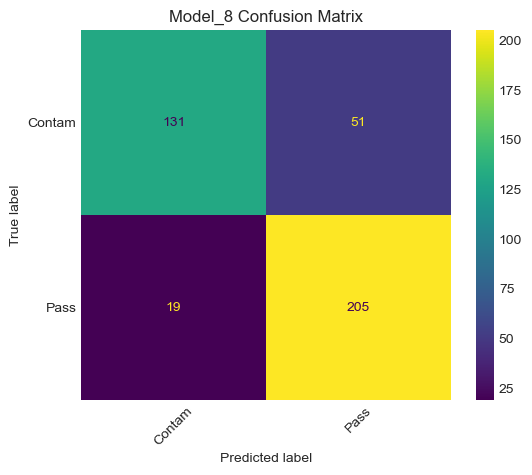

Found 1902 images belonging to 2 classes.


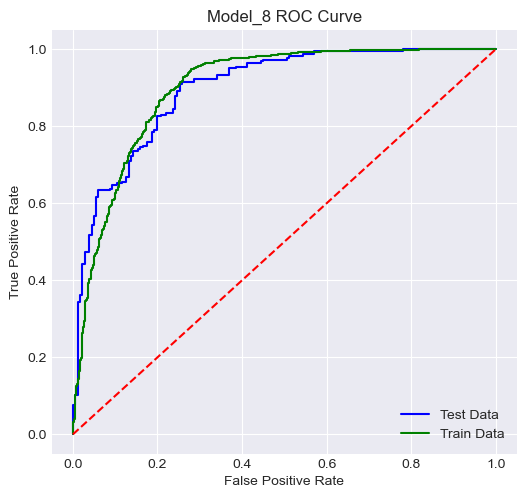

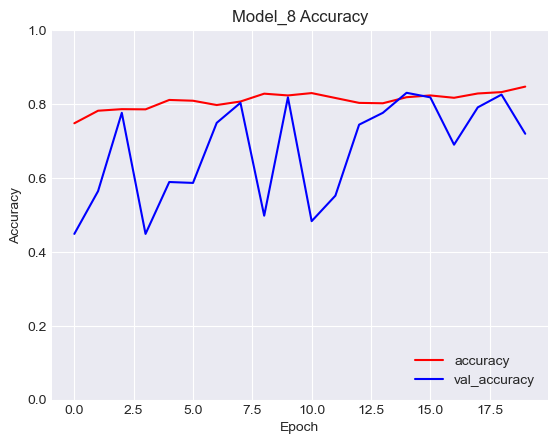

In [57]:
report_binary_results(model, history, test_generator)

In [52]:
model_results_df

,Model,Scale Factor,Train Accuracy,Val Accuracy,Test Accuracy
0,Model_8,0.5,0.818134,0.830049,0.827586


---
---
---

In [35]:
train_dir = 'data/raw/images_sorted_multiclass/Sets/Train'
val_dir = 'data/raw/images_sorted_multiclass/Sets/Validation'
test_dir = 'data/raw/images_sorted_multiclass/Sets/Test'

In [36]:
model_name = 'Model_Multi_13'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.55
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='valid'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),

    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# instantiate early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)


# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.summary()

Found 3281 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Found 699 images belonging to 4 classes.
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 516, 561, 32)      320       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 258, 280, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 256, 278, 64)      18496     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 128, 139, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 126, 137, 128)     73856 

In [37]:
# fit the model
history = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=validation_generator,
                class_weight=class_weight_dict,
                callbacks=[early_stopping])

Epoch 1/100
 22/205 [==>...........................] - ETA: 12:20 - loss: 1.6570 - categorical_accuracy: 0.2983

KeyboardInterrupt: 

---
---
---

---
---
### Unpickle best Multi Model

In [12]:
# define the image data paths
train_dir = 'data/raw/images_sorted_multiclass/Sets_with_etch/Train'
val_dir = 'data/raw/images_sorted_multiclass/Sets_with_etch/Validation'
test_dir = 'data/raw/images_sorted_multiclass/Sets_with_etch/Test'

In [13]:
model_name = 'Model_Multi_21'
num_epochs = 100
original_width = 1024
original_height = 943
scale_factor = 0.35
target_size = (int(original_height*scale_factor), int(original_width*scale_factor))

# Instantiate an ImageDataGenerator for the training set with augmentations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   horizontal_flip=True,
                                   zoom_range=0.05,
                                   height_shift_range=0.05,
                                   brightness_range=[0.8, 1.2]
)

# Instantiate an ImageDataGenerator for the validation set without augmentations
val_datagen = ImageDataGenerator(rescale=1./65535)

# Instantiate the test generator
test_datagen = ImageDataGenerator(rescale=1./65535)

# create the train generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical',
        seed=42
)

# create the validation generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size= target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)

# create the test generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        shuffle=False,
        color_mode='grayscale',
        class_mode='categorical',
)


# Get the input shape
input_shape = (target_size[0], target_size[1], 1)

# Define the model
padding = 'valid'
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=input_shape,
           padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding=padding),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),

    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

# optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


Found 4919 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


In [19]:
# Load the weights from the .pkl file
# from tensorflow.keras.models import load_model
model.load_weights('Models\\Model_Multi_21.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 328, 356, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 164, 178, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 162, 176, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 81, 88, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 79, 86, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 39, 43, 128)       0

33/33 [==============================] - 30s 917ms/step
      Test Accuracy: 0.847
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       249
           1       0.52      0.72      0.61        92
           2       0.85      0.87      0.86       155
           3       0.94      0.91      0.93       376
           4       0.87      0.83      0.85       178

    accuracy                           0.85      1050
   macro avg       0.81      0.83      0.81      1050
weighted avg       0.86      0.85      0.85      1050



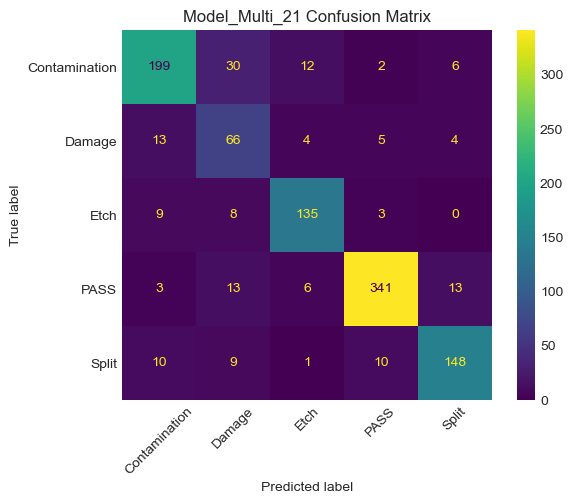

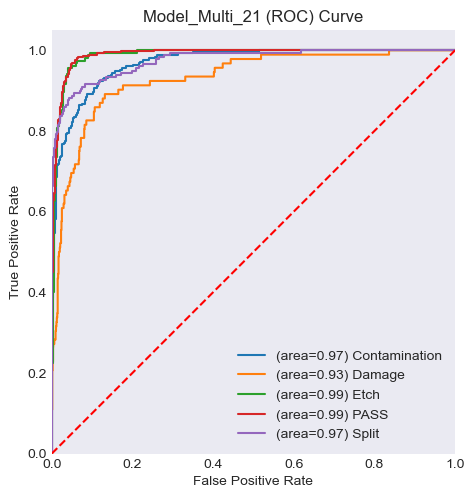

In [22]:
report_multi_results(model_name, scale_factor, model, test_generator, metric='accuracy', val_metric='val_accuracy')

In [23]:
model_path = 'models\Model_Multi_21.h5'
model.save(model_path)

In [24]:
from tensorflow.keras.models import load_model
model = load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 328, 356, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 164, 178, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 162, 176, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 81, 88, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 79, 86, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 39, 43, 128)       0

In [33]:
multi_results_df = pd.read_csv('data/multi_results.csv')
multi_results_df

,Model,Scale Factor,Train Accuracy,Val Accuracy,Test Accuracy
0,Model_Multi_0,0.35,1.000000,0.845494,0.844063
1,Model_Multi_1,0.35,0.588668,0.583691,0.565093
2,Model_Multi_2,0.35,0.415314,0.536481,0.517883
3,Model_Multi_3,0.35,0.821133,0.816881,0.812589
4,Model_Multi_4,0.35,0.125000,0.336195,0.329041
5,Model_Multi_5,0.35,0.262787,0.320458,0.320458
6,Model_Multi_6,0.35,0.937500,0.812589,0.802575
7,Model_Multi_7,0.55,0.829403,0.859800,0.854077
8,Model_Multi_8,0.60,0.854518,0.834049,0.841202
9,Model_Multi_9,0.60,0.750000,0.802575,0.763949


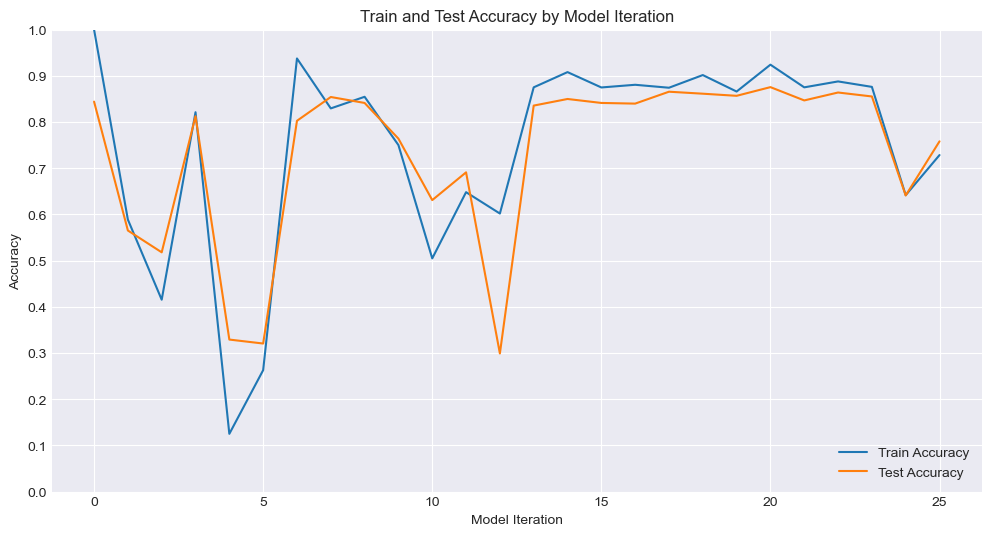

In [34]:
# Display a graph of accuracy for the training and test sets by model iteration
multi_results_df = pd.read_csv('data/multi_results.csv')
# remove index 21
multi_results_df = multi_results_df.drop(21)
multi_results_df = multi_results_df.reset_index(drop=True)

plt.plot(multi_results_df['Train Accuracy'], label='Train Accuracy')
plt.plot(multi_results_df['Test Accuracy'], label = 'Test Accuracy')
plt.xlabel('Model Iteration')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Train and Test Accuracy by Model Iteration')
plt.legend(loc='lower right')
# yticks every 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
# size the plot
plt.gcf().set_size_inches(12, 6)
plt.show()
